# Linear regression with Python: `bambi`, `pymc`, `arviz`, and `loo`

This workshop's goal—which is facilitated by this notebook—is to give attendees the confidence to conduct Bayesian regression analyses with `Python` for their research projects.

[`bambi`](https://bambinos.github.io/bambi/) is a high-level Bayesian model-building interface written in `Python`.

[`pymc`](https://www.pymc.io/welcome.html) allows you to write down Bayesian models using an intuitive syntax to describe a data generating process.

[`arviz`](https://python.arviz.org/en/stable/index.html) is a `Python` package for exploratory analysis of Bayesian models.

[`loo`](https://mc-stan.org/loo/index.html) allows users to compute efficient approximate leave-one-out cross-validation for fitted Bayesian models, as well as model weights that can be used to average predictive distributions.

To motivate this workshop, we'll work with examples from [Regression and Other Stories](https://avehtari.github.io/ROS-Examples/examples.html) and go through the various steps of conducting regression analyses in a [Bayesian workflow](https://arxiv.org/abs/2011.01808). Hopefully, you will come away feeling confident you can use `Python` to conduct regression analyses for your research projects.

# Table of Contents

## Linear regression with [`bambi`](https://bambinos.github.io/bambi/)

- ### An intercept

- ### A binary predictor

- ### A continuous predictor

- ### Two predictors (no interaction)

- ### Model comparison

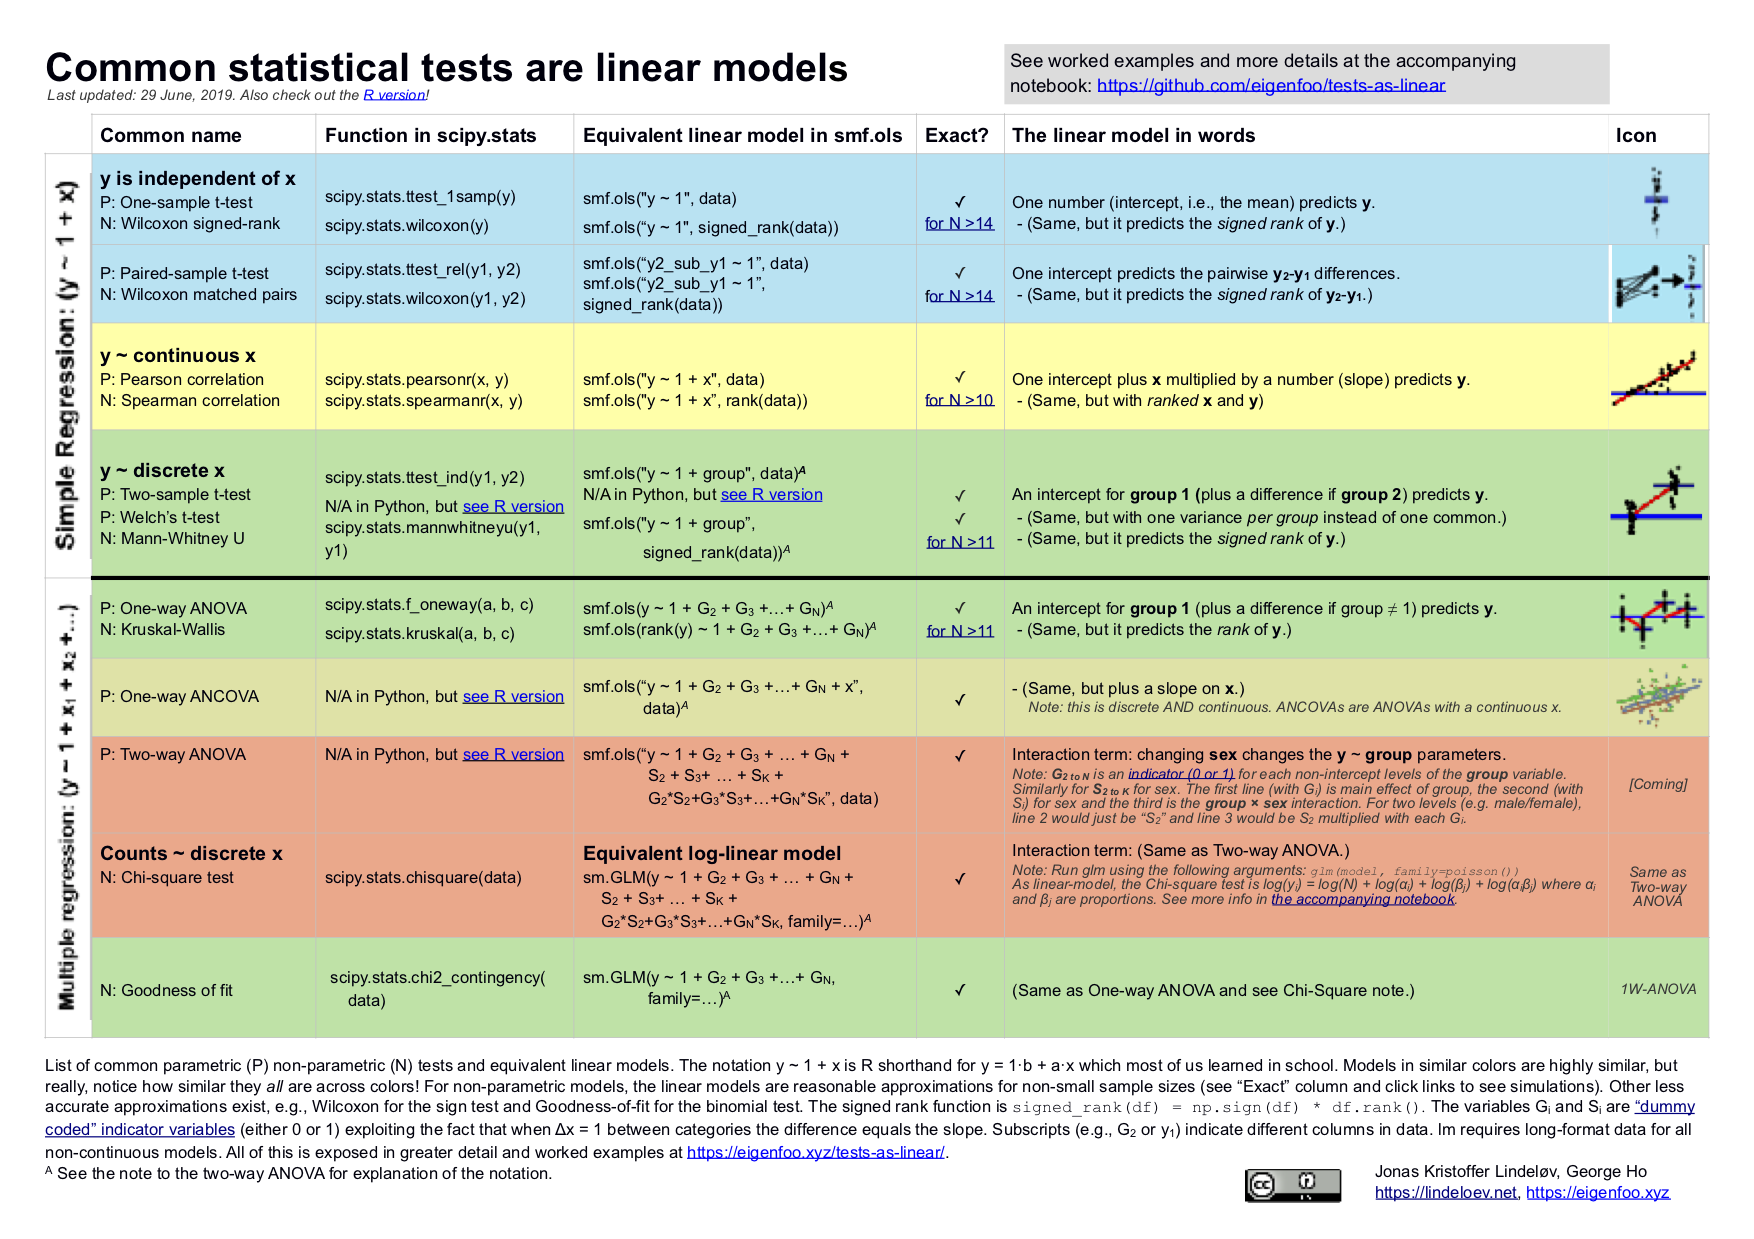

---

## Load packages

In [ ]:
!pip install git+https://github.com/bambinos/bambi.git

In [ ]:
from datetime import datetime

import random
import numpy as np
from numpy.random import default_rng
from numpy.polynomial.polynomial import polyfit
from scipy import stats
from scipy.special import expit, logit
from scipy.interpolate import interp1d, make_interp_spline, BSpline
import pandas as pd
from pandas.api.types import CategoricalDtype
import xarray as xr

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('tableau-colorblind10')

import seaborn as sns
sns.set_style("white")
sns.set_context("notebook")

import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px

import patsy
from patsy import dmatrices
import statsmodels
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

import pymc as pm
import bambi as bmb
import arviz as az

from IPython.display import HTML
from IPython.display import Markdown as md

import warnings
warnings.filterwarnings('ignore')

md('Analysis last performed on {}.'.format(datetime.today().strftime('%m/%d/%Y')))

Analysis last performed on 10/27/2023.

In [ ]:
RANDOM_SEED = 58
rng = np.random.default_rng(RANDOM_SEED)

## List pre-defined style sheets provided by matplotlib:

In [ ]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'arviz-bluish',
 'arviz-brownish',
 'arviz-colors',
 'arviz-cyanish',
 'arviz-darkgrid',
 'arviz-doc',
 'arviz-docgrid',
 'arviz-grayscale',
 'arviz-greenish',
 'arviz-orangish',
 'arviz-plasmish',
 'arviz-purplish',
 'arviz-redish',
 'arviz-royish',
 'arviz-viridish',
 'arviz-white',
 'arviz-whitegrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

## Visualization in Bayesian workflow
- ### Plot data
- ### Plot model
- ### Plot prior parameter distributions
- ### Plot prior predictive distributions
- ### Plot MCMC diagnostics
- ### Plot posterior parameter distributions
- ### Plot posterior predictive distributions
- ### Plot model comparisons

## Load Data into DataFrame

The data used in these examples is available in the following [GitHub repository](https://github.com/avehtari/ROS-Examples/tree/master). For this example, we're working with the `kidiq` dataset from [Regression and Other Stories](https://avehtari.github.io/ROS-Examples/examples.html).

In [ ]:
# SOURCE: https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html

# Load data into a DataFrame
kidiq = pd.read_csv('https://raw.githubusercontent.com/cbrownley/2023ODSCWest/main/data/kidiq.csv')
kidiq.round(1)

kid_score  mom_hs  mom_iq  mom_work  mom_age
0           65       1   121.1         4       27
1           98       1    89.4         4       25
2           85       1   115.4         4       27
3           83       1    99.4         3       25
4          115       1    92.7         4       27
..         ...     ...     ...       ...      ...
429         94       0    84.9         4       21
430         76       1    93.0         4       23
431         50       0    94.9         2       24
432         88       1    96.9         2       21
433         70       1    91.3         2       25

[434 rows x 5 columns]

## Explore Data

In [ ]:
# SOURCE: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.isna.html

# Check for missing values
kidiq.isna().sum()

kid_score    0
mom_hs       0
mom_iq       0
mom_work     0
mom_age      0
dtype: int64

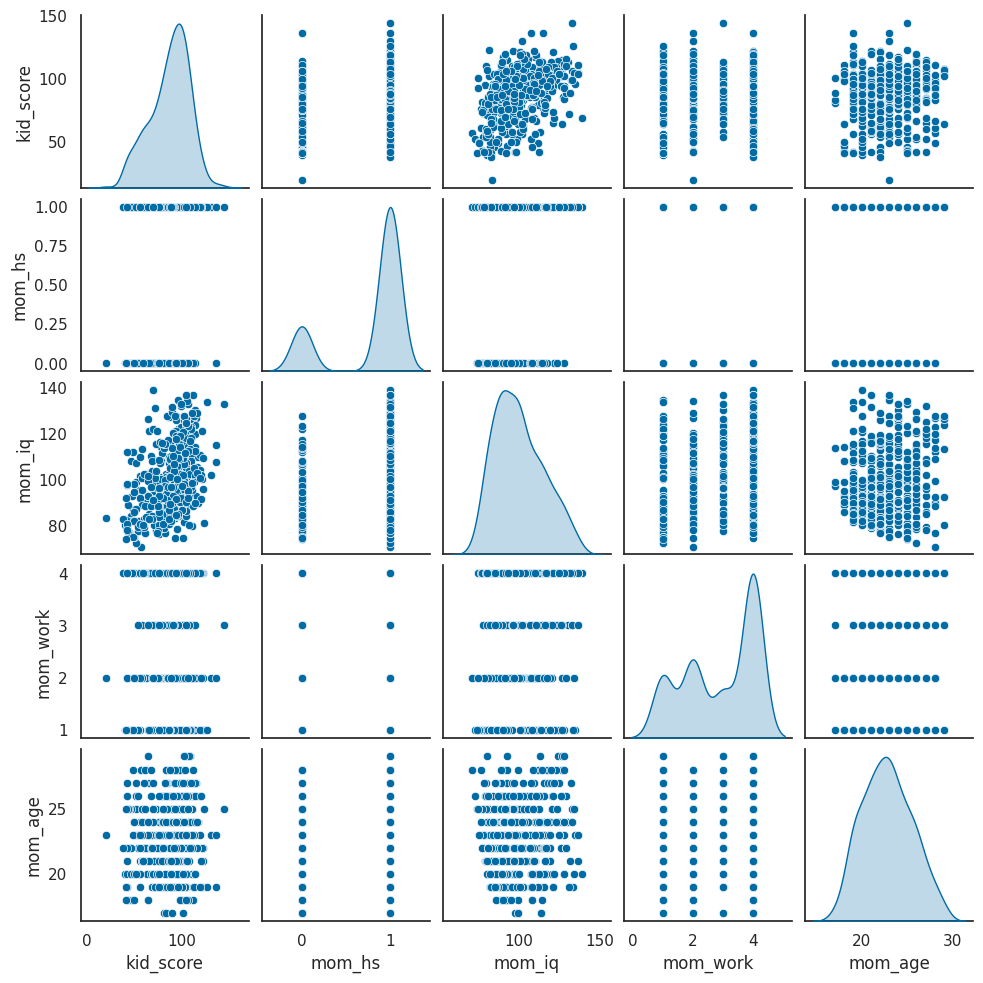

In [ ]:
# SOURCE: https://seaborn.pydata.org/generated/seaborn.pairplot.html

# Review the joint distribution of the variables in the dataset
sns.pairplot(kidiq, diag_kind='kde', height=2, aspect=1);

In [ ]:
# SOURCE: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html

# Review the summary statistics for the variables in the dataset
kidiq.describe().round(decimals=1)  # transpose().round(decimals=1)

kid_score  mom_hs  mom_iq  mom_work  mom_age
count      434.0   434.0   434.0     434.0    434.0
mean        86.8     0.8   100.0       2.9     22.8
std         20.4     0.4    15.0       1.2      2.7
min         20.0     0.0    71.0       1.0     17.0
25%         74.0     1.0    88.7       2.0     21.0
50%         90.0     1.0    97.9       3.0     23.0
75%        102.0     1.0   110.3       4.0     25.0
max        144.0     1.0   138.9       4.0     29.0

In [ ]:
# SOURCE: https://www.statsmodels.org/stable/generated/statsmodels.stats.descriptivestats.describe.html

# Review the summary statistics for the variables in the dataset
statsmodels.stats.descriptivestats.describe(kidiq).round(2)

kid_score  mom_hs  mom_iq  mom_work  mom_age
nobs                 434.00  434.00  434.00    434.00   434.00
missing                0.00    0.00    0.00      0.00     0.00
mean                  86.80    0.79  100.00      2.90    22.79
std_err                0.98    0.02    0.72      0.06     0.13
upper_ci              88.72    0.82  101.41      3.01    23.04
lower_ci              84.88    0.75   98.59      2.79    22.53
std                   20.41    0.41   15.00      1.18     2.70
iqr                   28.00    0.00   21.61      2.00     4.00
iqr_normal            20.76    0.00   16.02      1.48     2.97
mad                   16.41    0.34   12.34      1.07     2.22
mad_normal            20.57    0.42   15.46      1.34     2.78
coef_var               0.24    0.52    0.15      0.41     0.12
range                124.00    1.00   67.86      3.00    12.00
max                  144.00    1.00  138.89      4.00    29.00
min                   20.00    0.00   71.04      1.00    17.00
skew                  -0.46   -1.39    0.47     -0.45     0.18
kurtosis               2.83    2.94    2.42      1.62     2.36
jarque_bera           15.88  140.35   21.80     48.95     9.65
jarque_bera_pval       0.00    0.00    0.00      0.00     0.01
mode                  94.00    1.00   97.60      4.00    23.00
mode_freq              0.04    0.79    0.01      0.47     0.15
median                90.00    1.00   97.92      3.00    23.00
1%                    41.00    0.00   75.02      1.00    18.00
5%                    49.00    0.00   79.36      1.00    19.00
10%                   56.30    0.00   81.68      1.00    19.00
25%                   74.00    1.00   88.66      2.00    21.00
50%                   90.00    1.00   97.92      3.00    23.00
75%                  102.00    1.00  110.27      4.00    25.00
90%                  110.00    1.00  121.83      4.00    26.00
95%                  114.35    1.00  127.58      4.00    27.00
99%                  125.01    1.00  134.45      4.00    29.00

---

# 1. An intercept (a column of 1s)

## Estimating a mean is the same as regressing on a constant term

We start by modeling the children's test scores with an intercept (a column of 1s), which summarizes the children's overall mean test score.  As shown by the coefficient for the Intercept, the children's overall mean test score is about 87.

## Plot data

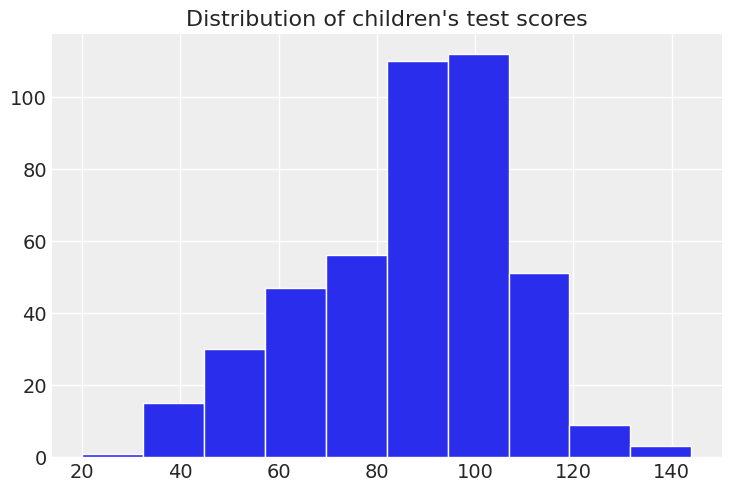

In [ ]:
plt.hist(kidiq.kid_score)
plt.title("Distribution of children's test scores");

In [ ]:
# Mean of children's test scores
kidiq.kid_score.mean().round(1)

86.8

In [ ]:
# Standard deviation of children's test scores
kidiq.kid_score.std().round(1)

20.4

## Plot model

Produce a [graph](https://bambinos.github.io/bambi/api/Model.html#bambi.Model.graph)viz Digraph from a built Bambi model.  

The graph shows that, in the model, `kid_score` is distributed as a normal, [Gaussian distribution](https://distribution-explorer.github.io/continuous/normal.html), with a mean (`Intercept`) that is also normally-distributed and a standard deviation (`kid_score_sigma`) that is distributed has a [Half-Student-t distribution](https://distribution-explorer.github.io/continuous/halfstudent_t.html).

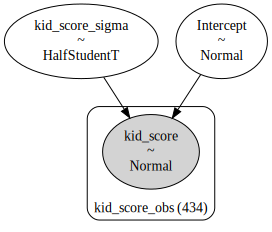

In [ ]:
m1 = bmb.Model('kid_score ~ 1', data=kidiq)

m1.build()

m1.graph()

In [ ]:
m1

       Formula: kid_score ~ 1
        Family: gaussian
          Link: mu = identity
  Observations: 434
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 86.7972, sigma: 50.9679)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 20.3872)

## Plot prior parameter distributions

[Prior Choice Recommendations](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations)

1. Flat prior (not usually recommended).

2. Super-vague but proper prior: normal(0, 1e6) (not usually recommended).

3. Weakly informative prior, very weak: normal(0, 10).

4. Generic weakly informative prior: normal(0, 1).

5. Specific informative prior: normal(0.4, 0.2) or whatever. Sometimes this can be expressed as a scaling followed by a generic prior: theta = 0.4 + 0.2*z ; z ~ normal(0, 1).

The above numbers assume that parameters are roughly on unit scale, as is done in education (where 0 is average test score in some standard population (e.g., all students at a certain grade level) and 1 is sd of test scores in that population) or medicine (where 0 is zero dose and 1 is a standard dose such as 10mcg/day of cyanocobalamin, 1,000 IU/day cholecalciferol, etc.; these examples come from Sander Greenland).

In addition, statements such as "informative" or "weakly informative" depend crucially on what questions are being asked (a point that is related to the idea that [the prior can often only be understood in the context of the likelihood](http://www.stat.columbia.edu/~gelman/research/published/entropy-19-00555-v2.pdf)).

[Default (Weakly Informative) Prior Distributions](https://mc-stan.org/rstanarm/articles/priors.html)

With very few exceptions, the default priors in [`rstanarm`](https://mc-stan.org/rstanarm/articles/priors.html) —the priors used if they aren't specified— are not flat priors. Rather, the defaults are intended to be weakly informative. That is, they are designed to provide moderate regularization and help stabilize computation. For many (if not most) applications the defaults will perform well, but this is not guaranteed (there are no default priors that make sense for every possible model specification).

[Prior predictive checks](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html) are also a crucial part of the Bayesian modeling workflow. Basically, they have two main benefits:

* They allow you to check whether you are indeed incorporating scientific knowledge into your model - in short, they help you check how credible your assumptions before seeing the data are.

* They can help sampling considerably, especially for generalized linear models, where the outcome space and the parameter space diverge because of the link function.

[`Model.plot_priors`](https://bambinos.github.io/bambi/api/Model.html#bambi.Model.plot_priors): Samples from the [prior](https://bambinos.github.io/bambi/api/Model.html#bambi.Model.plot_priors) distribution and plots its marginals.

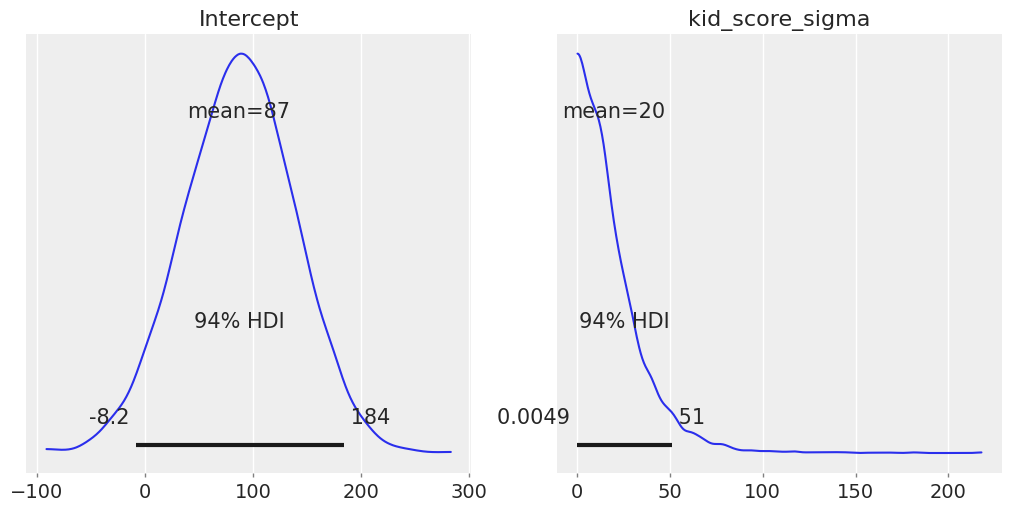

In [ ]:
m1.plot_priors(figsize=(10,5));

## Fit model

[Fit](https://bambinos.github.io/bambi/api/Model.html#bambi.Model.fit) the model using PyMC.

`draws`: The number of samples to draw from the posterior distribution. Defaults to `1000`.

`tune`: Number of iterations to tune. Defaults to `1000`.

`chains`: The number of chains to sample. Running independent chains is important for some convergence statistics and can also reveal multiple modes in the posterior. If `None` (default), then set to either `cores` or `2`, whichever is larger.

`inference_method`: The method to use for fitting the model. By default, [`"mcmc"`](https://www.bayesrulesbook.com/chapter-7). This automatically assigns a [MCMC](https://mc-stan.org/docs/reference-manual/hmc.html) method best suited for each kind of variables, like [NUTS](https://mc-stan.org/docs/reference-manual/hmc-algorithm-parameters.html) for continuous variables and [Metropolis](https://mc-stan.org/docs/reference-manual/hmc.html) for non-binary discrete ones. Alternatively, `"vi"`, in which case the model will be fitted using [variational inference](https://mc-stan.org/docs/reference-manual/vi-algorithms.html) as implemented in PyMC using the `fit` function.

[Markov Chain Monte Carlo (MCMC)](https://bookdown.org/content/4857/markov-chain-monte-carlo.html): This chapter introduces one commonplace example of [Fortuna](https://en.wikipedia.org/wiki/Rota_Fortunae#/media/File:Lydgate-siege-troy-wheel-fortune-detail.jpg) and [Minerva](https://en.wikipedia.org/wiki/Minerva#/media/File:Minerva-Vedder-Highsmith-detail-1.jpeg)'s cooperation: the estimation of posterior probability distributions using a stochastic process known as **Markov chain Monte Carlo (MCMC)** ([McElreath, 2020a, p. 263](https://bookdown.org/content/4857/markov-chain-monte-carlo.html#ref-mcelreathStatisticalRethinkingBayesian2020), **emphasis** in the original).

[Model log-likelihood](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/model_comparison.html#model-log-likelihood)

In order to compute [`LOO`](https://python.arviz.org/en/stable/api/generated/arviz.loo.html) and [`WAIC`](https://python.arviz.org/en/stable/api/generated/arviz.waic.html), [`ArviZ`](https://python.arviz.org/en/stable/index.html) needs access to the model elemwise loglikelihood for every posterior sample. We can pass `idata_kwargs={"log_likelihood": True}` to have it computed automatically at the end of sampling.

In [ ]:
# https://discourse.pymc.io/t/using-az-compare-with-bambi-models/12301/3
# idata = pm.compute_log_likelihood(idata)

m1_fit = m1.fit(idata_kwargs=dict(log_likelihood=True))

m1_fit

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

[Introduction to xarray, InferenceData, and netCDF for ArviZ](https://python.arviz.org/en/stable/getting_started/XarrayforArviZ.html)

[Bayesian inference](https://en.wikipedia.org/wiki/Bayesian_inference) generates numerous datasets that represent different aspects of the model. For example, in a single analysis, a Bayesian practitioner could end up with any of the following data.

* Prior Distribution for N number of variables

* Posterior Distribution for N number of variables

* Prior Predictive Distribution

* Posterior Predictive Distribution

* Trace data for each of the above

* Sample statistics for each inference run

* Any other array like data source

[`InferenceData`](https://python.arviz.org/en/stable/getting_started/XarrayforArviZ.html#additional-reading)

* [Working with `InferenceData`](https://python.arviz.org/en/stable/getting_started/WorkingWithInferenceData.html#working-with-inferencedata): Tutorial covering the most common operations with `InferenceData` objects

* [Creating `InferenceData`](https://python.arviz.org/en/stable/getting_started/CreatingInferenceData.html#creating-inferencedata): Cookbook with examples of generating `InferenceData` objects from multiple sources, both external inference libraries like

* [data module API reference](https://python.arviz.org/en/stable/api/data.html#data-api)

* [`InferenceData` API reference](https://python.arviz.org/en/stable/api/inference_data.html#idata-api): description of all available `InferenceData` methods, grouped by topic

[`InferenceData` schema specification](https://python.arviz.org/en/stable/schema/schema.html)

* [Terminology](https://python.arviz.org/en/stable/schema/schema.html#terminology)

* [Rules](https://python.arviz.org/en/stable/schema/schema.html#rules)

* [Metadata](https://python.arviz.org/en/stable/schema/schema.html#metadata)

* [Relations between groups](https://python.arviz.org/en/stable/schema/schema.html#relations-between-groups)

* [Example of schema](https://python.arviz.org/en/stable/schema/PyMC3_schema_example.html)

In [ ]:
# Rename parameters
# Assign to new variable because renaming interferes with later step:
# posterior_predictive = m1.predict(m1_fit, kind="pps")
m1_fit_renamed = m1_fit.rename_vars({"Intercept": "mu", "kid_score_sigma": "sigma"})
m1_fit_renamed

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

## Plot MCMC diagnostics

[`az.ess`](https://python.arviz.org/en/stable/api/generated/arviz.ess.html): Calculate estimate of the effective sample size (`ess`). The effective sample size is an estimate of the number of independent draws from the posterior distribution of the estimand of interest. The 𝑛𝑒𝑓𝑓 metric used in Stan is based on the ability of the draws to estimate the true mean value of the parameter, which is related to (but not necessarily equivalent to) estimating other functions of the draws. Because the draws within a Markov chain are not independent if there is autocorrelation, the effective sample size, 𝑛𝑒𝑓𝑓, is usually smaller than the total sample size, 𝑁 (although it may be larger in some cases1). The larger the ratio of 𝑛𝑒𝑓𝑓 to 𝑁 the better (see Gelman et al. 2013, Stan Development Team 2018 for more details).

[`az.rhat`](https://python.arviz.org/en/stable/api/generated/arviz.rhat.html): Compute estimate of rank normalized splitR-hat for a set of traces.  The rank normalized [`R-hat`](https://mc-stan.org/bayesplot/articles/visual-mcmc-diagnostics.html#rhat-potential-scale-reduction-statistic) diagnostic tests for lack of convergence by comparing the variance between multiple chains to the variance within each chain.  If convergence has been achieved, the between-chain and within-chain variances should be identical.  To be most effective in detecting evidence for nonconvergence, each chain should have been initialized to starting values that are dispersed relative to the target distribution.


[`az.mcse`](https://python.arviz.org/en/stable/api/generated/arviz.mcse.html): Calculate Markov Chain Standard Error (`mcse`) statistic.  The [Monte Carlo standard error](https://jrnold.github.io/bayesian_notes/mcmc-diagnostics.html) is the uncertainty about a statistic in the sample due to sampling error. With a independent sample of size N, the MCSE for the sample mean is MCSE(θbar) = s / √N , where s is the sample standard deviation.
However, MCMC are generally not independent, and the MCSE will be higher than that of an independent sample. One way to calculate the MCSE with autocorrelated samples is to use the effective sample size instead of the sample size, MCSE(θbar) = s / √Neff.

[`az.plot_trace`](https://python.arviz.org/en/stable/examples/plot_trace.html) distribution (histogram or kernel density estimates) and sampled values or rank plot.  If `divergences` data is available in `sample_stats`, will plot the location of divergences as dashed vertical lines.

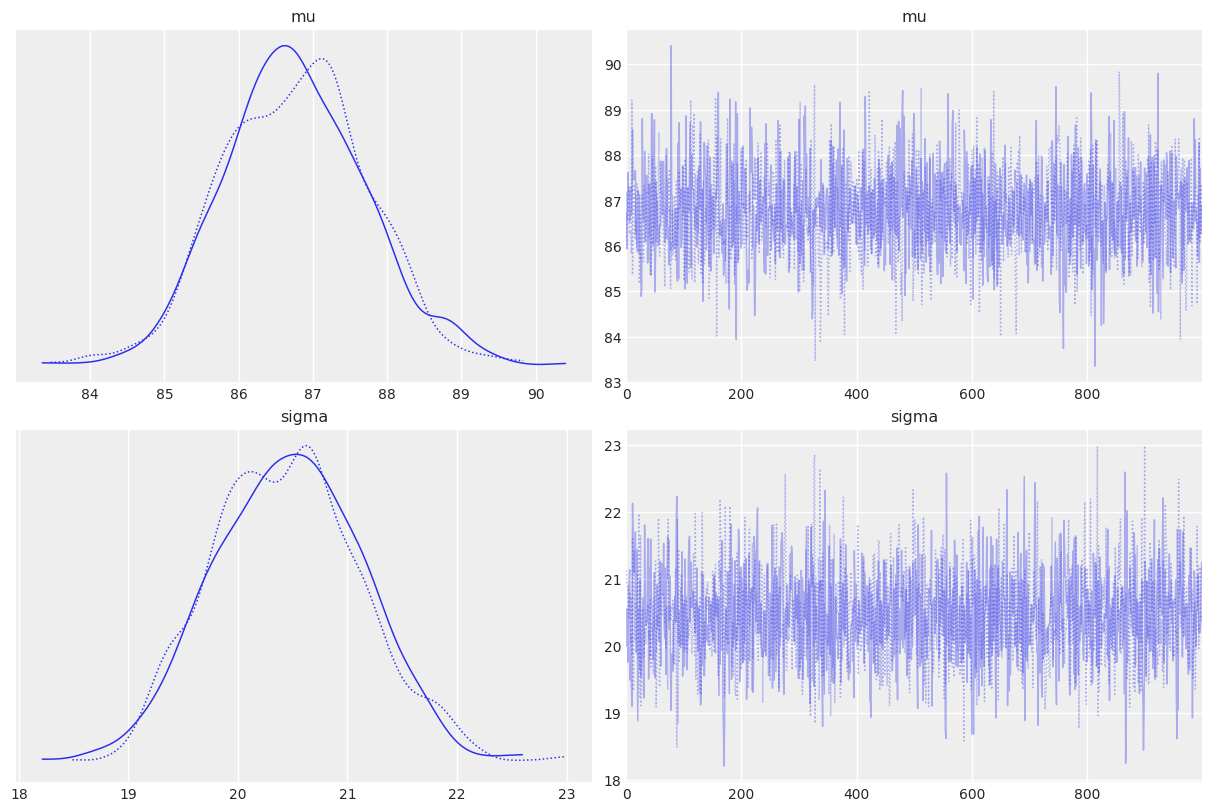

In [ ]:
az.plot_trace(m1_fit_renamed, figsize=(12,8));

## Plot posterior distributions

The [posterior probability](https://en.wikipedia.org/wiki/Posterior_probability) is a type of [conditional probability](https://en.wikipedia.org/wiki/Conditional_probability) that results from [updating](https://en.wikipedia.org/wiki/Bayesian_updating) the [prior probability](https://en.wikipedia.org/wiki/Prior_probability) with information summarized by the [likelihood](https://en.wikipedia.org/wiki/Likelihood_function) via an application of [Bayes' rule](https://en.wikipedia.org/wiki/Bayes%27_rule).

Chapter 7 [The Posterior - The Goal of Bayesian
Inference](https://sites.math.rutgers.edu/~zeilberg/EM20/Lambert.pdf) in "A Student's Guide to Bayesian Statistics" by Ben Lambert

[`az.plot_posterior`](https://python.arviz.org/en/stable/examples/plot_posterior.html): Plot Posterior densities in the style of John K. Kruschke's [book](https://sites.google.com/site/doingbayesiandataanalysis/).

[`az.plot_pair`](https://python.arviz.org/en/stable/examples/plot_pair.html): Plot a scatter, kde and/or hexbin matrix with (optional) marginals on the diagonal.

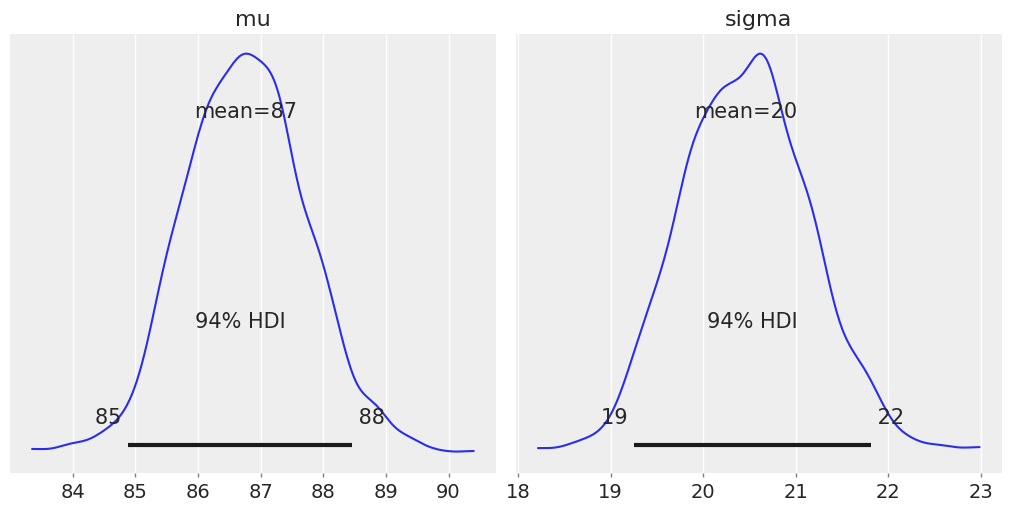

In [ ]:
az.plot_posterior(m1_fit_renamed, figsize=(10,5));

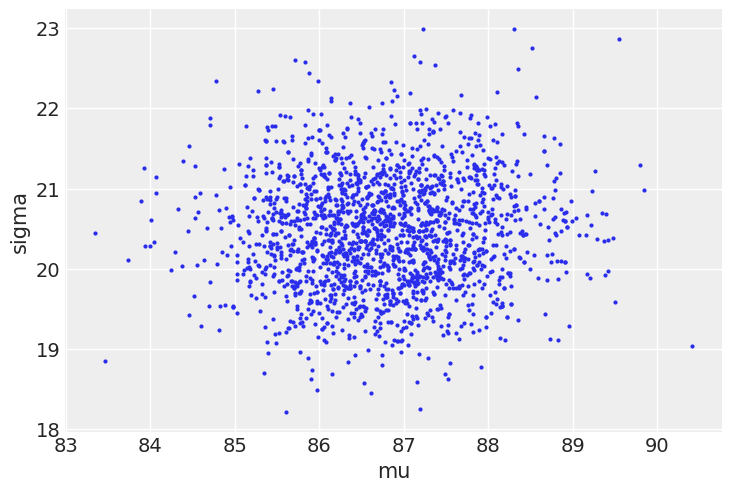

In [ ]:
az.plot_pair(m1_fit_renamed);

[`az.summary`](https://python.arviz.org/en/stable/api/generated/arviz.summary.html): Create a data frame with summary statistics.

In [ ]:
az.summary(m1_fit_renamed).round(2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu     86.76  0.96   84.89    88.46       0.02     0.02    2104.0    1495.0   
sigma  20.46  0.70   19.25    21.82       0.02     0.01    2054.0    1330.0   

       r_hat  
mu       1.0  
sigma    1.0

In [ ]:
# m1_df = az.extract_dataset(m1_fit).to_dataframe() # [['Intercept', 'kid_score_sigma']]

m1_df = az.extract_dataset(m1_fit_renamed).to_dataframe()[['mu', 'sigma']]
m1_df.round(2)

mu  sigma
chain draw              
0     0     86.11  20.00
      1     86.72  20.56
      2     85.93  20.32
      3     87.62  19.76
      4     87.12  20.89
...           ...    ...
1     995   88.40  20.47
      996   86.06  21.18
      997   87.32  20.69
      998   86.27  20.38
      999   87.34  20.49

[2000 rows x 2 columns]

In [ ]:
m1_df.describe().T.round(2)

count   mean   std    min    25%    50%    75%    max
mu     2000.0  86.76  0.96  83.35  86.09  86.75  87.39  90.41
sigma  2000.0  20.46  0.70  18.21  19.96  20.46  20.92  22.99

In [ ]:
m1_df.cov()

mu     sigma
mu     0.929925  0.027073
sigma  0.027073  0.488048

In [ ]:
# m1_fit.posterior["Intercept"][0][:10] # .to_pandas() or .to_series()

m1_fit_renamed.posterior["mu"][0][:10] # .to_pandas() or .to_series()

<xarray.DataArray 'mu' (draw: 10)>
array([86.10670741, 86.71832485, 85.93316879, 87.61729949, 87.11591744,
       87.24029764, 86.52581689, 86.66991641, 87.29692203, 86.69273848])
Coordinates:
    chain    int64 0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9

In [ ]:
# m1_fit.posterior["kid_score_sigma"][0][:10]

m1_fit_renamed.posterior["sigma"][0][:10]

<xarray.DataArray 'sigma' (draw: 10)>
array([20.00217666, 20.55612079, 20.3158095 , 19.76093704, 20.88729646,
       20.93976702, 21.14292368, 19.49446588, 20.16112508, 19.39874747])
Coordinates:
    chain    int64 0
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 9

In [ ]:
stats.multivariate_normal.rvs(mean=m1_df.mean(), cov=m1_df.cov(), size=10)

array([[86.69494265, 21.26636469],
       [86.3693384 , 20.02050468],
       [85.7408238 , 21.43741006],
       [88.21109262, 20.05339712],
       [86.86170275, 19.98555895],
       [86.60769224, 19.62134706],
       [86.70380926, 20.95372458],
       [86.10846282, 20.24627318],
       [86.5226126 , 20.49073013],
       [88.54988403, 20.1936339 ]])

## Plot posterior predictive distributions

[Posterior predictive checks (PPCs)](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/posterior_predictive.html) are a great way to validate a model. The idea is to generate data from the model using parameters from draws from the posterior.

Elaborating slightly, one can say that PPCs analyze the degree to which data generated from the model deviate from data generated from the true distribution. So, often you will want to know if, for example, your posterior distribution is approximating your underlying distribution. The visualization aspect of this model evaluation method is also great for a 'sense check' or explaining your model to others and getting criticism.

[Graphical posterior predictive checks (PPCs)](https://mc-stan.org/bayesplot/articles/graphical-ppcs.html)

The `bayesplot` package provides various plotting functions for graphical posterior predictive checking, that is, creating graphical displays comparing observed data to simulated data from the posterior predictive distribution ([Gabry et al, 2019](https://mc-stan.org/bayesplot/articles/graphical-ppcs.html#gabry2019)).

The idea behind [posterior predictive checking](https://mc-stan.org/docs/stan-users-guide/posterior-prediction.html) is simple: if a model is a good fit then we should be able to use it to generate data that looks a lot like the data we observed. To generate the data used for posterior predictive checks (PPCs) we simulate from the posterior predictive distribution. This is the distribution of the outcome variable implied by a model after using the observed data 𝑦 (a vector of 𝑁 outcome values) to update our beliefs about unknown model parameters 𝜃.

[Predict method for Bambi models](https://bambinos.github.io/bambi/api/Model.html#bambi.Model.predict)

Obtains in-sample and out-of-sample predictions from a fitted Bambi model.

`kind` indicates the type of prediction required. Can be `"mean"` or `"pps"`. The first returns draws from the posterior distribution of the mean, while the latter returns the draws from the posterior predictive distribution. Defaults to "mean".

If `kind="mean"`, a new variable ending in `"_mean"` is added to the `posterior` group. If `kind="pps"`, it appends a `posterior_predictive` group to `idata`. If any of these already exist, it will be overwritten.

In [ ]:
posterior_predictive = m1.predict(m1_fit, kind="pps")
m1_fit

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

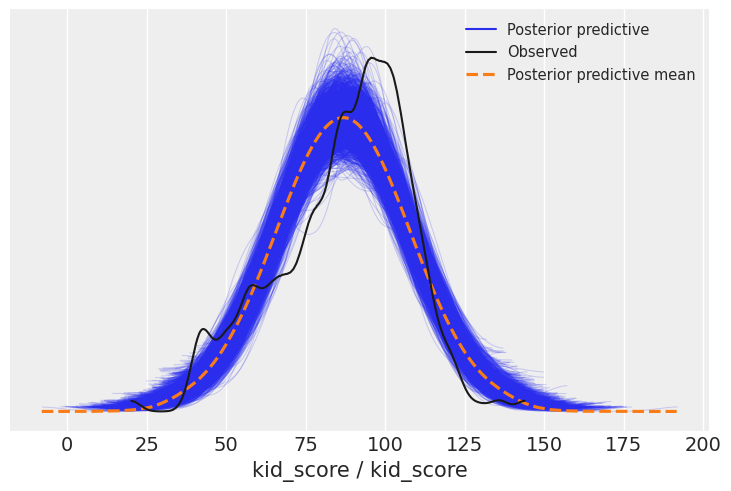

In [ ]:
az.plot_ppc(m1_fit);

[loo](https://mc-stan.org/loo/index.html): Efficient approximate leave-one-out cross-validation for fitted Bayesian models

From existing posterior simulation draws, we compute approximate `LOO-CV` using Pareto smoothed importance sampling (`PSIS`), a new procedure for regularizing importance weights. As a byproduct of our calculations, we also obtain approximate standard errors for estimated predictive errors and for comparing predictive errors between two models. We recommend `PSIS-LOO-CV` instead of `WAIC`, because `PSIS` provides useful diagnostics and effective sample size and Monte Carlo standard error estimates.

[`az.loo`](https://python.arviz.org/en/stable/api/generated/arviz.loo.html): Compute Pareto-smoothed importance sampling leave-one-out cross-validation (PSIS-LOO-CV).

Estimates the expected log pointwise predictive density (elpd) using Pareto-smoothed importance sampling leave-one-out cross-validation (PSIS-LOO-CV). Also calculates LOO's standard error and the effective number of parameters. Read more theory here https://arxiv.org/abs/1507.04544 and here https://arxiv.org/abs/1507.02646

In [ ]:
loo1 = az.loo(m1_fit)
loo1

Computed from 2000 posterior samples and 434 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1926.22    14.10
p_loo        1.86        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      434  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

[LOO package glossary](https://mc-stan.org/loo/reference/loo-glossary.html)

`elpd`: approximated expected log pointwise predictive density (elpd).

`se`: standard error of the elpd.

`p_loo`: effective number of parameters. If we have a well-specified model, we expect the estimated effective number of parameters (`p_loo`) to be smaller than or similar to the total number of parameters in the model.

Pareto 𝑘 diagnostic values are used to assess the reliability of the estimates. In addition to the proportion of leave-one-out folds with 𝑘 values in different intervals, the minimum of the effective sample sizes in that category is shown to give idea why higher 𝑘 values are bad.

---

# An index variable (or a binary indicator)

### Estimating a difference is the same as regressing on an indicator variable (Student's two-sample t-test)

## Summarize variables

In [ ]:
kidiq.groupby('mom_hs')['kid_score'].describe().round(1)

count  mean   std   min   25%   50%    75%    max
mom_hs                                                   
0        93.0  77.5  22.6  20.0  58.0  80.0   95.0  136.0
1       341.0  89.3  19.0  38.0  77.0  92.0  103.0  144.0

## Plot data

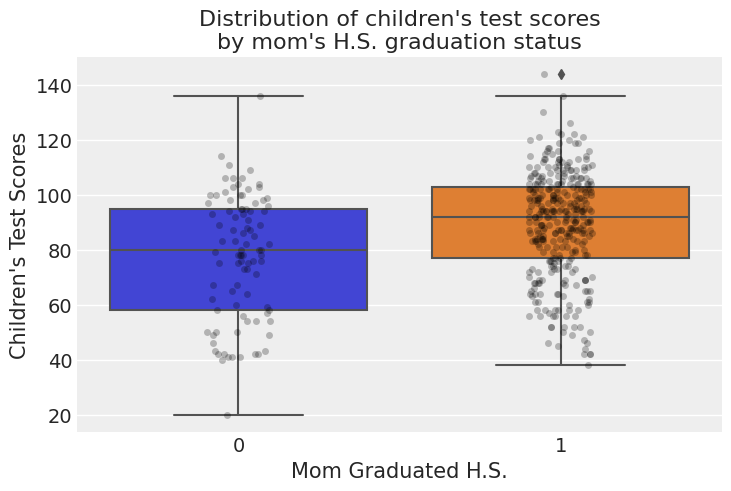

In [ ]:
sns.boxplot(x='mom_hs', y='kid_score', data=kidiq)
sns.stripplot(x='mom_hs', y='kid_score', data=kidiq, color='black', alpha=0.25)
sns.despine(left=True, bottom=True)
plt.xlabel('Mom Graduated H.S.')
plt.ylabel('Children\'s Test Scores')
plt.title("Distribution of children's test scores\nby mom's H.S. graduation status");

In [ ]:
sns.set_style("whitegrid")

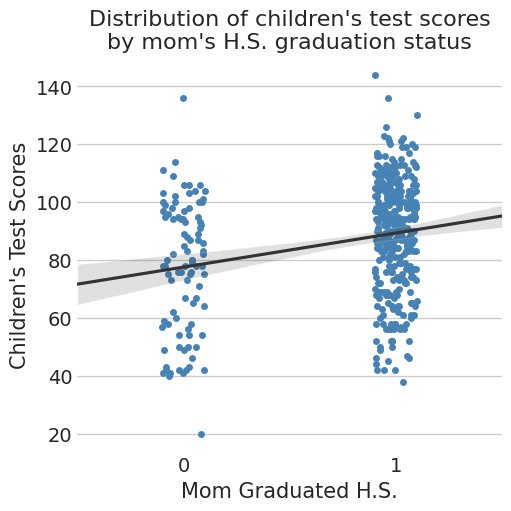

In [ ]:
sns.catplot(data=kidiq, x="mom_hs", y="kid_score", color="steelblue", zorder=1)
sns.regplot(data=kidiq, x="mom_hs", y="kid_score", scatter=False, truncate=False, color=".2")
#sns.despine(left=True, bottom=True)
plt.xlabel('Mom Graduated H.S.')
plt.ylabel('Children\'s Test Scores')
plt.title("Distribution of children's test scores\nby mom's H.S. graduation status");

## Plot model

In [ ]:
# kidiq['mom_hs'] = kidiq.mom_hs.astype('category')

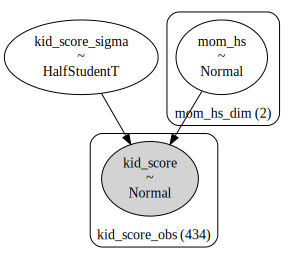

In [ ]:
m2 = bmb.Model('kid_score ~ 0 + mom_hs', data=kidiq, categorical=['mom_hs'])

m2.build()

m2.graph()

In [ ]:
m2

       Formula: kid_score ~ 0 + mom_hs
        Family: gaussian
          Link: mu = identity
  Observations: 434
        Priors: 
    target = mu
        Common-level effects
            mom_hs ~ Normal(mu: [0. 0.], sigma: [124.2132 124.2132])
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 20.3872)

## Plot prior parameter distributions

In [ ]:
az.style.use('arviz-darkgrid')

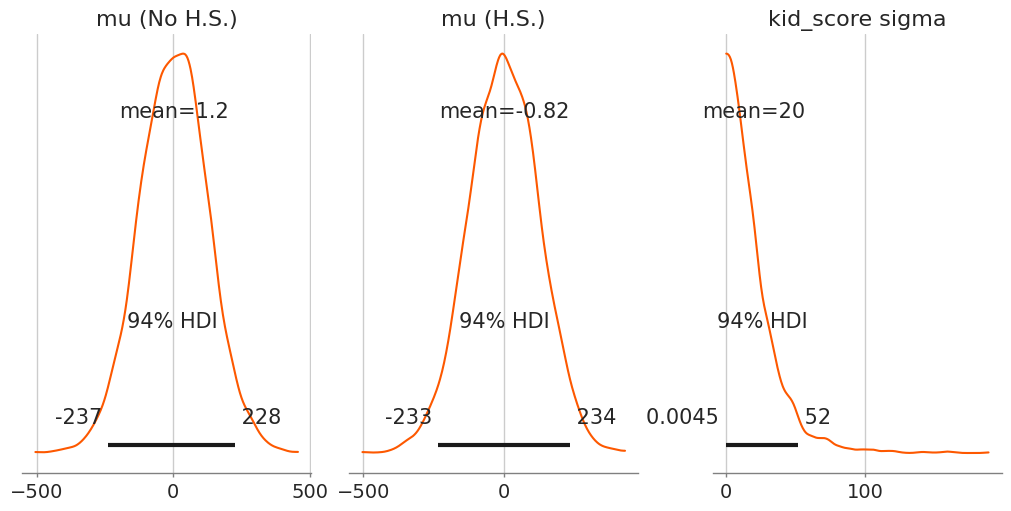

In [ ]:
axs = m2.plot_priors(var_names=['mom_hs', 'kid_score_sigma'], figsize=(10,5))

titles = ['mu (No H.S.)', 'mu (H.S.)', 'kid_score sigma']
for i, ax in enumerate(axs.flat):
    ax.set_title(titles[i])
plt.tight_layout();

## Fit model

In [ ]:
# https://discourse.pymc.io/t/using-az-compare-with-bambi-models/12301/3
# idata = pm.compute_log_likelihood(idata)

m2_fit = m2.fit(idata_kwargs=dict(log_likelihood=True))

m2_fit

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [ ]:
#m2_fit_renamed = m2_fit.rename_vars({"mom_hs": "mu", "kid_score_sigma": "sigma"})
#m2_fit_renamed

## Plot MCMC diagnostics

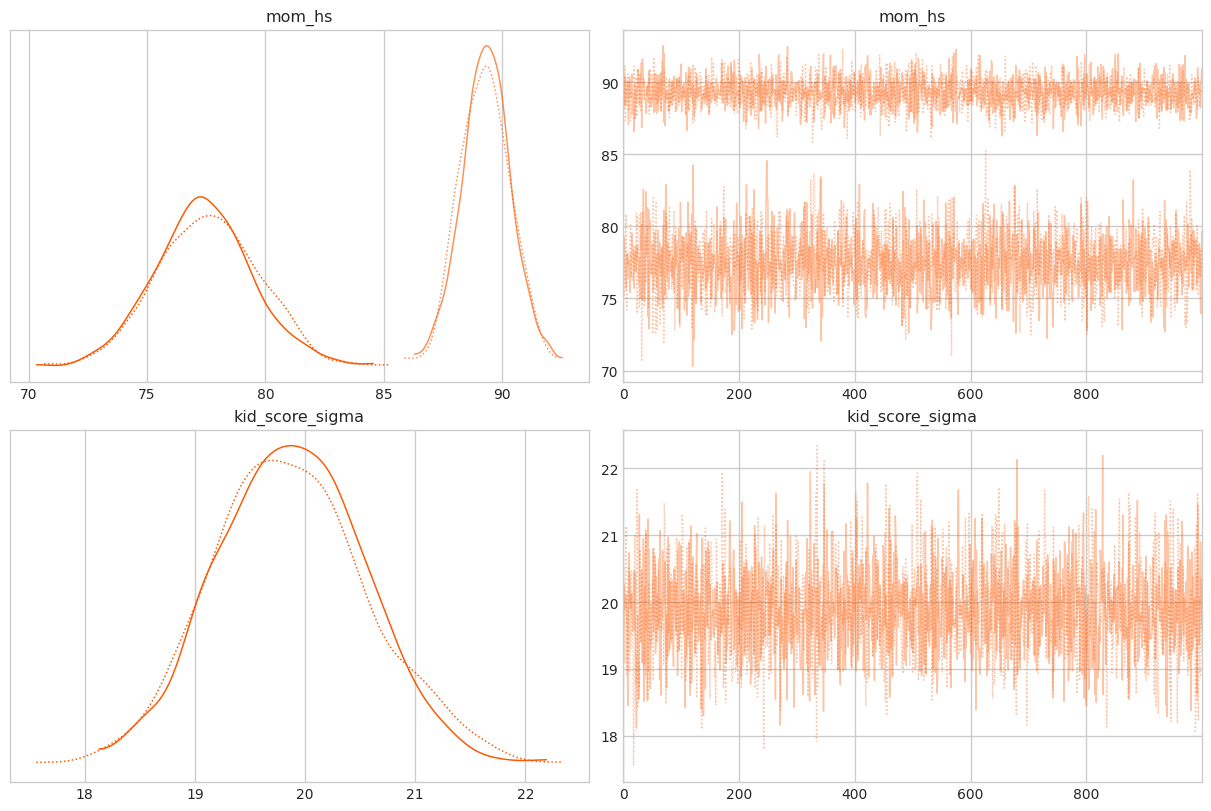

In [ ]:
az.plot_trace(m2_fit, figsize=(12,8));

## Plot posterior distributions

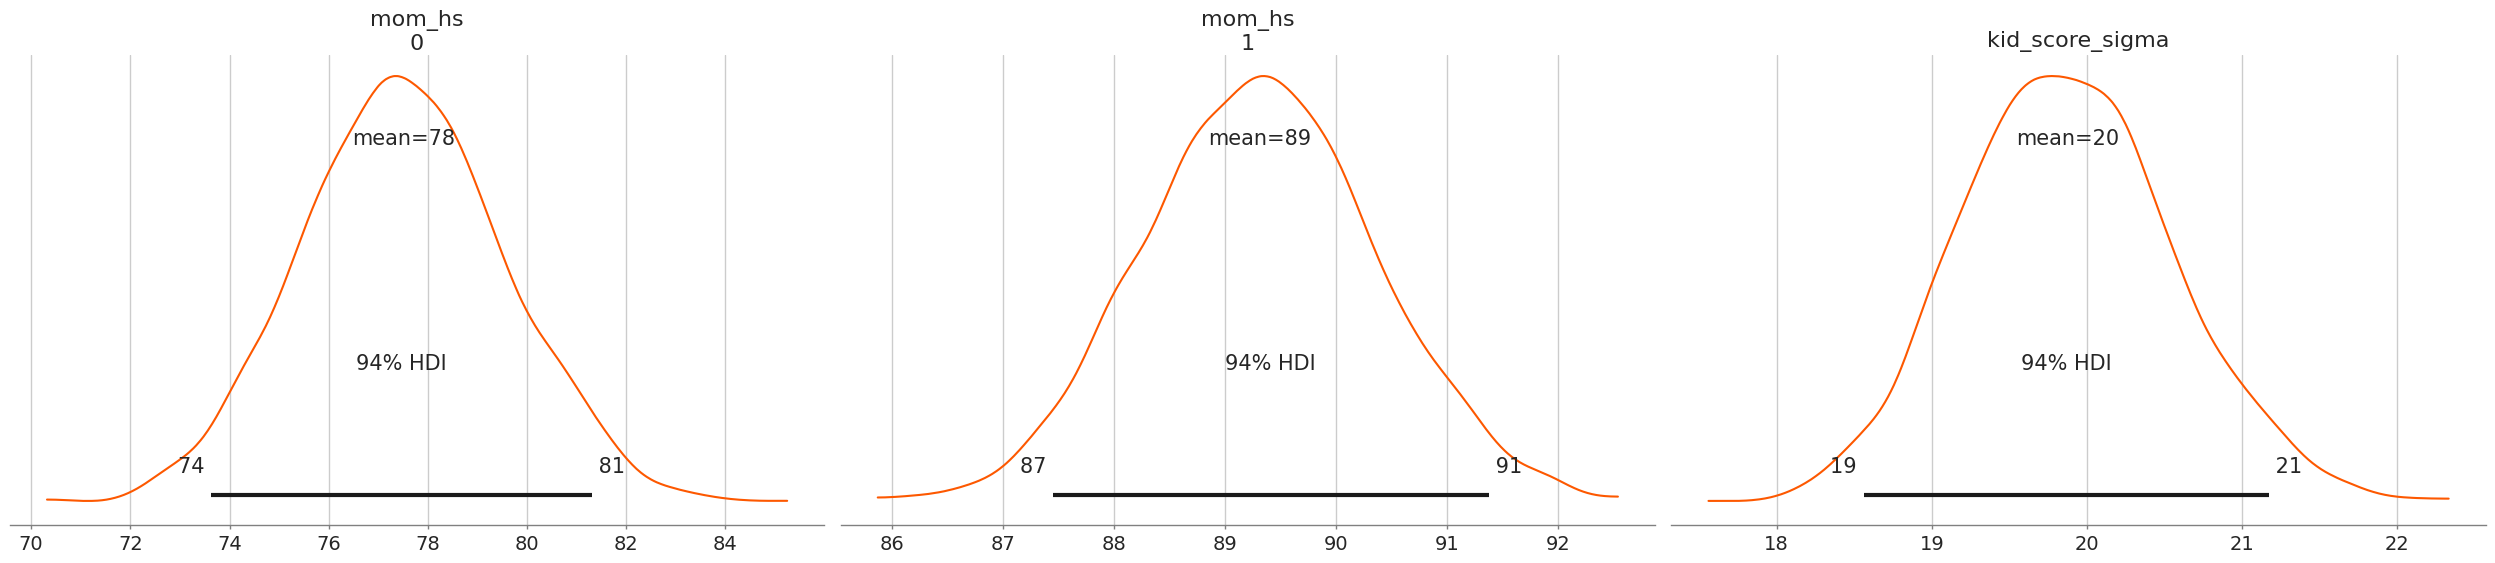

In [ ]:
az.plot_posterior(m2_fit);

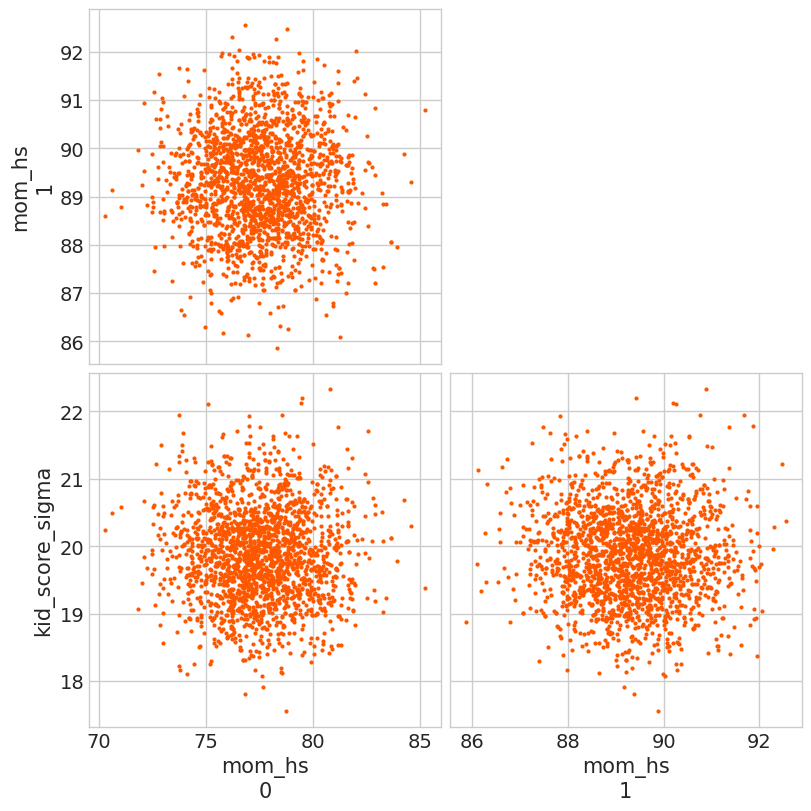

In [ ]:
az.plot_pair(m2_fit, figsize=(8,8));

In [ ]:
m2_df = az.extract_dataset(m2_fit).to_dataframe()[['mom_hs', 'kid_score_sigma']].unstack(level=0)
m2_df

mom_hs            kid_score_sigma           
mom_hs_dim          0          1               0          1
chain draw                                                 
0     0     76.570049  88.471248       19.431702  19.431702
      1     78.023523  90.470085       19.808055  19.808055
      2     79.249777  90.021968       20.261605  20.261605
      3     77.723373  88.476601       19.964318  19.964318
      4     76.571489  90.379649       19.893100  19.893100
...               ...        ...             ...        ...
1     995   77.268984  88.357173       20.076360  20.076360
      996   78.543434  89.283503       18.959218  18.959218
      997   76.478629  89.493026       18.910308  18.910308
      998   78.436489  89.368196       20.361694  20.361694
      999   77.103308  89.409954       19.250783  19.250783

[2000 rows x 4 columns]

In [ ]:
m2_df.describe().T.round(2)

count   mean   std    min    25%    50%    75%  \
                mom_hs_dim                                                    
mom_hs          0           2000.0  77.50  2.08  70.30  76.10  77.48  78.83   
                1           2000.0  89.31  1.05  85.86  88.61  89.31  90.02   
kid_score_sigma 0           2000.0  19.88  0.69  17.56  19.40  19.86  20.31   
                1           2000.0  19.88  0.69  17.56  19.40  19.86  20.31   

                              max  
                mom_hs_dim         
mom_hs          0           85.26  
                1           92.55  
kid_score_sigma 0           22.34  
                1           22.34

## Interpret results

In [ ]:
az.summary(m2_fit).round(1)

mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mom_hs[0]        77.5  2.1    73.6     81.3        0.0      0.0    2867.0   
mom_hs[1]        89.3  1.0    87.4     91.4        0.0      0.0    3187.0   
kid_score_sigma  19.9  0.7    18.6     21.2        0.0      0.0    2889.0   

                 ess_tail  r_hat  
mom_hs[0]          1535.0    1.0  
mom_hs[1]          1751.0    1.0  
kid_score_sigma    1365.0    1.0

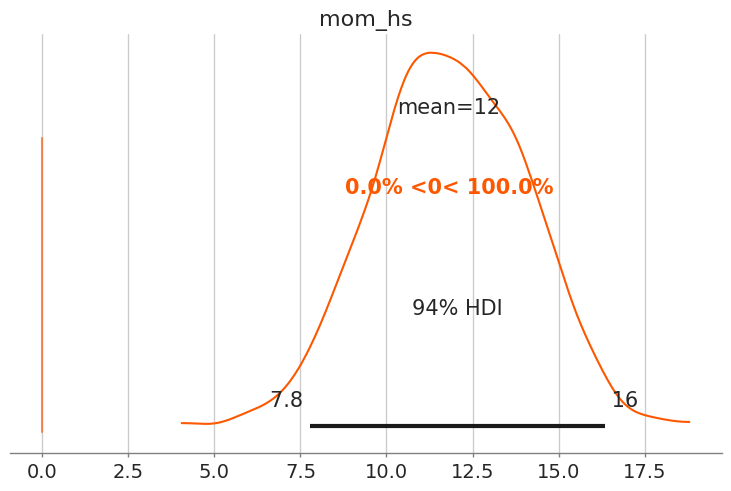

In [ ]:
post_mom_hs = m2_fit.posterior["mom_hs"]

diff = post_mom_hs.sel(mom_hs_dim="1") - post_mom_hs.sel(mom_hs_dim="0")

az.plot_posterior(diff, ref_val=0);

In [ ]:
# Probabiliy that posterior is > 0
(post_mom_hs > 0).mean().item()

1.0

In [ ]:
posterior_predictive = m2.predict(m2_fit, kind="pps")
m2_fit

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

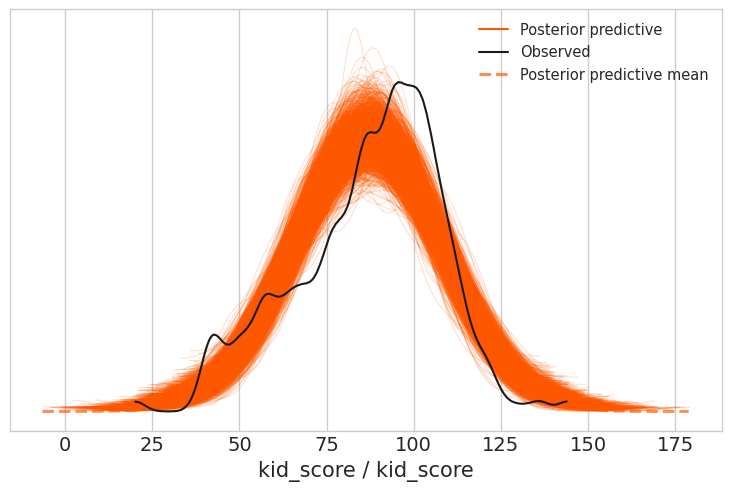

In [ ]:
az.plot_ppc(m2_fit);

In [ ]:
loo2 = az.loo(m2_fit)
loo2

Computed from 2000 posterior samples and 434 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1914.84    13.82
p_loo        3.11        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      434  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

## Double-check with another [model](https://bambinos.github.io/bambi/notebooks/t-test.html#model-1)

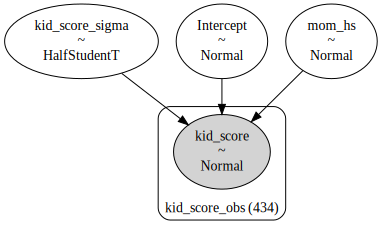

In [ ]:
m2b = bmb.Model('kid_score ~ 1 + mom_hs', data=kidiq)

m2b.build()

m2b.graph()

In [ ]:
m2b

       Formula: kid_score ~ 1 + mom_hs
        Family: gaussian
          Link: mu = identity
  Observations: 434
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 86.7972, sigma: 110.1032)
            mom_hs ~ Normal(mu: 0.0, sigma: 124.2132)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 20.3872)

In [ ]:
m2b_fit = m2b.fit()
m2b_fit

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [ ]:
az.summary(m2b_fit).round(1)

mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept        77.5  2.1    73.8     81.6        0.0      0.0    2876.0   
mom_hs           11.9  2.4     7.4     16.1        0.0      0.0    2790.0   
kid_score_sigma  19.9  0.7    18.6     21.2        0.0      0.0    2770.0   

                 ess_tail  r_hat  
Intercept          1425.0    1.0  
mom_hs             1475.0    1.0  
kid_score_sigma    1511.0    1.0

In [ ]:
posterior_predictive = m2b.predict(m2b_fit, kind="pps")
m2b_fit

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

In [ ]:
y_true = kidiq.kid_score.values

y_pred = m2b_fit.posterior_predictive.mean(dim=("chain", "draw"))["kid_score"].values.T

m2b_fit_r2_score = az.r2_score(y_true, y_pred)
m2b_fit_r2_score

r2        0.057659
r2_std    0.000000
dtype: float64

In [ ]:
# SOURCE: https://stackoverflow.com/questions/8671808/matplotlib-avoiding-overlapping-datapoints-in-a-scatter-dot-beeswarm-plot
def rand_jitter(arr):
    stdev = .01 * (max(arr) - min(arr))
    return arr + np.random.randn(len(arr)) * stdev

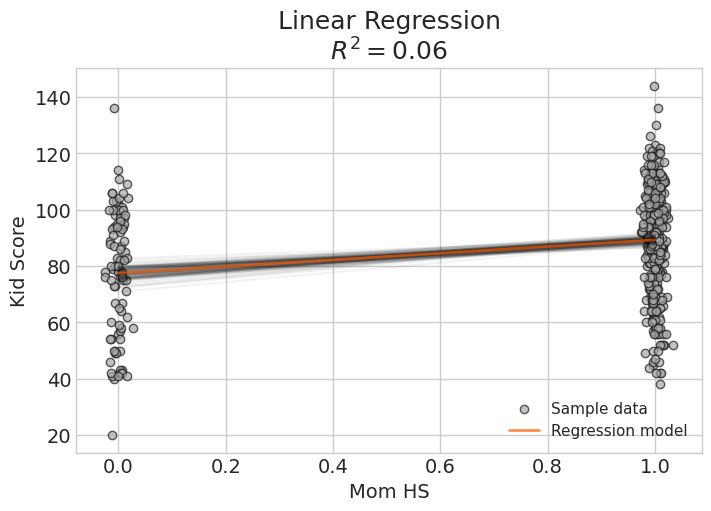

In [ ]:
# SOURCE: https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM.html

# Initialize random number generator
RANDOM_SEED = 8927
rng = default_rng(RANDOM_SEED)

fig, ax = plt.subplots(figsize=(7, 5))

num_samples = 100

x_axis = xr.DataArray(np.linspace(0, 1, num=num_samples), dims=["x_plot"])
mu_pred = m2b_fit.posterior["Intercept"] + m2b_fit.posterior["mom_hs"] * x_axis
mu_mean = mu_pred.mean(dim=("chain", "draw"))
mu_plot = mu_pred.stack(sample=("chain", "draw")) # az.extract(mu_pred, num_samples=num_samples) # mu_pred.stack(sample=("chain", "draw"))
random_subset = rng.permutation(np.arange(len(mu_plot.sample)))[:100]

plt.scatter(rand_jitter(kidiq.mom_hs), kidiq.kid_score, edgecolor='k', facecolor='darkgray', alpha=0.7, label='Sample data')
plt.plot(x_axis, mu_plot.isel(sample=random_subset), color="black", alpha=0.05)
plt.plot(x_axis, mu_mean, color="C1", lw=2.0, label='Regression model')

ax.set_ylabel('Kid Score', fontsize=14)
ax.set_xlabel('Mom HS', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Linear Regression\n$R^2= %.2f$' % m2b_fit_r2_score[0], fontsize=18)

fig.tight_layout();

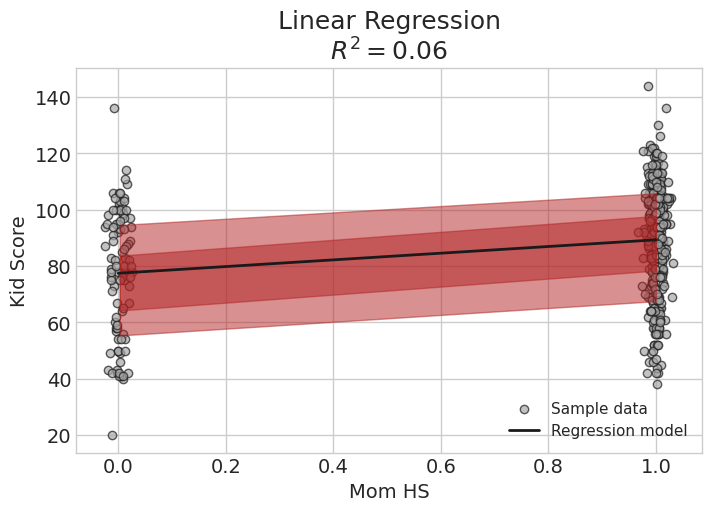

In [ ]:
# SOURCE: https://bambinos.github.io/bambi/main/notebooks/t_regression.html
fig, ax = plt.subplots(figsize=(7, 5))

# Plot data
ax.scatter(rand_jitter(kidiq.mom_hs), kidiq.kid_score, edgecolor='k', facecolor='darkgray', alpha=0.7, label='Sample data')


# Plot linear regression
x_range = np.linspace(min(kidiq.mom_hs), max(kidiq.mom_hs), 2000)
y_pred = m2b_fit.posterior.mom_hs.values.mean() * x_range + m2b_fit.posterior.Intercept.values.mean()
plt.plot(x_range, y_pred, color='k',linestyle='-', lw=2.0, label='Regression model')

# Plot HDIs
for interval in [0.38, 0.68]:
    az.plot_hdi(kidiq.mom_hs, m2b_fit.posterior_predictive.kid_score,
                hdi_prob=interval, color='firebrick')

ax.set_ylabel('Kid Score', fontsize=14)
ax.set_xlabel('Mom HS', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Linear Regression\n$R^2= %.2f$' % m2b_fit_r2_score[0], fontsize=18)

fig.tight_layout();

---

# A continuous variable

In [ ]:
sns.set_style("whitegrid")

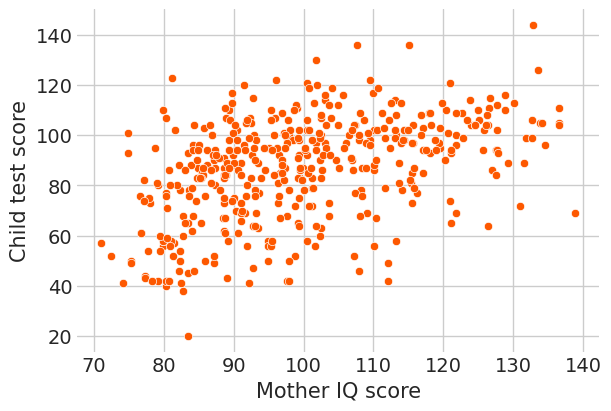

In [ ]:
f, ax = plt.subplots(figsize=(6, 4))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="mom_iq", y="kid_score", data=kidiq, ax=ax)
plt.xlabel('Mother IQ score')
plt.ylabel('Child test score');

## Plot model

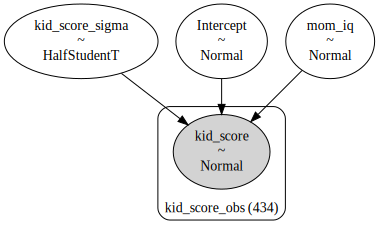

In [ ]:
m3 = bmb.Model('kid_score ~ 1 + mom_iq', data=kidiq)

m3.build()

m3.graph()

In [ ]:
m3

       Formula: kid_score ~ 1 + mom_iq
        Family: gaussian
          Link: mu = identity
  Observations: 434
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 86.7972, sigma: 343.9751)
            mom_iq ~ Normal(mu: 0.0, sigma: 3.4018)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 20.3872)

## Plot prior parameter distributions

In [ ]:
az.style.use(['arviz-whitegrid', 'arviz-orangish'])

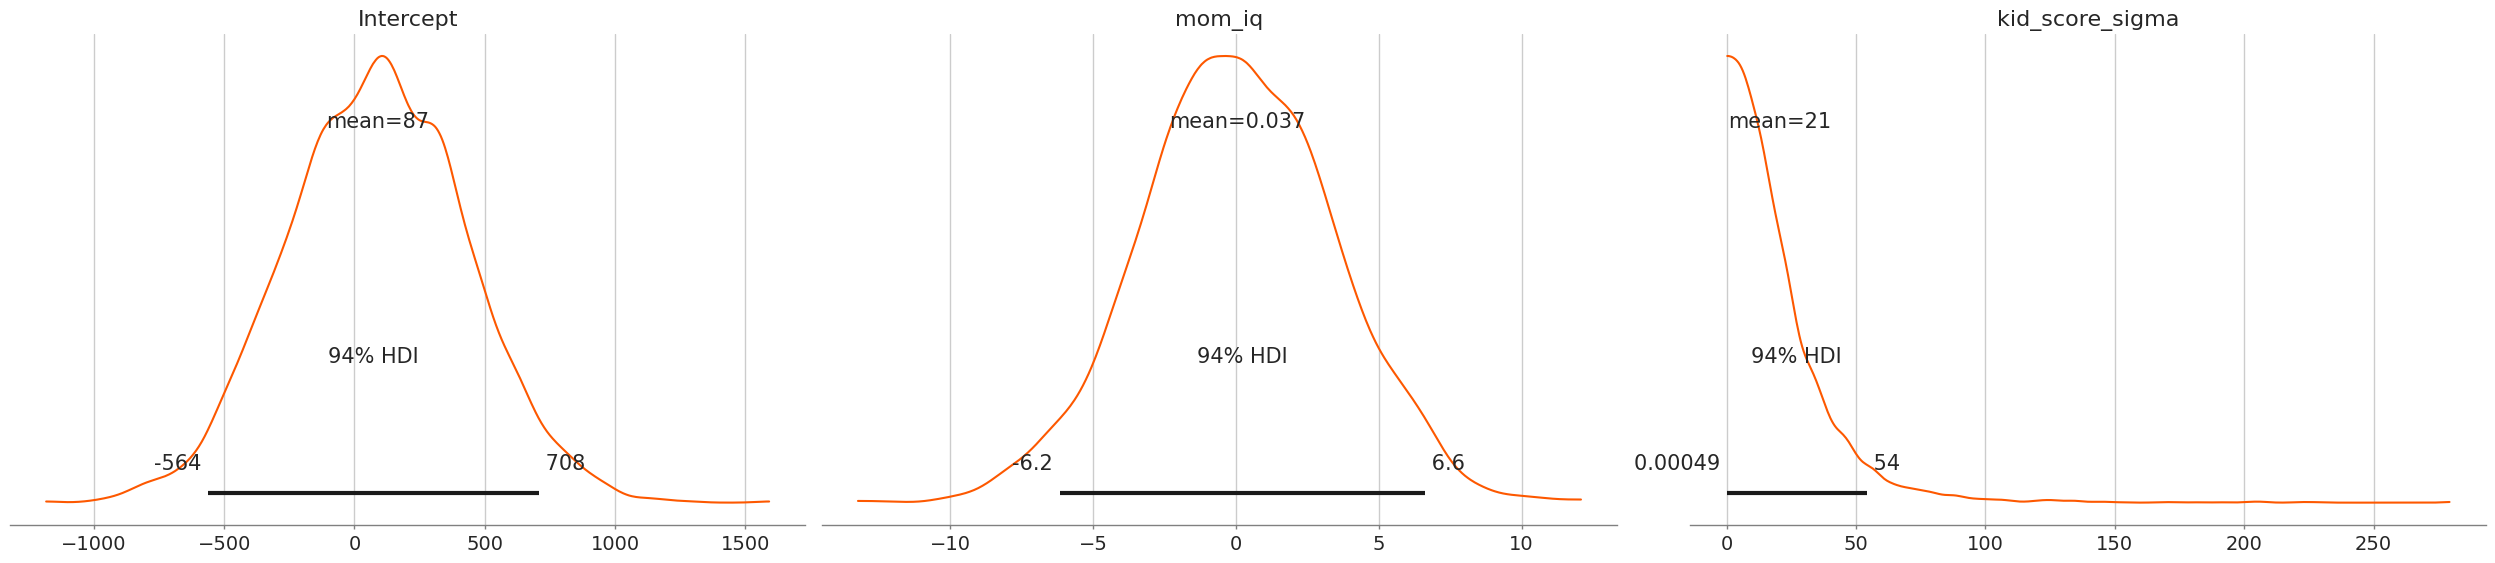

In [ ]:
m3.plot_priors(var_names=['Intercept', 'mom_iq', 'kid_score_sigma']);

## Fit model

In [ ]:
# https://discourse.pymc.io/t/using-az-compare-with-bambi-models/12301/3
# idata = pm.compute_log_likelihood(idata)

m3_fit = m3.fit(idata_kwargs=dict(log_likelihood=True))

m3_fit

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

## Plot MCMC diagnostics

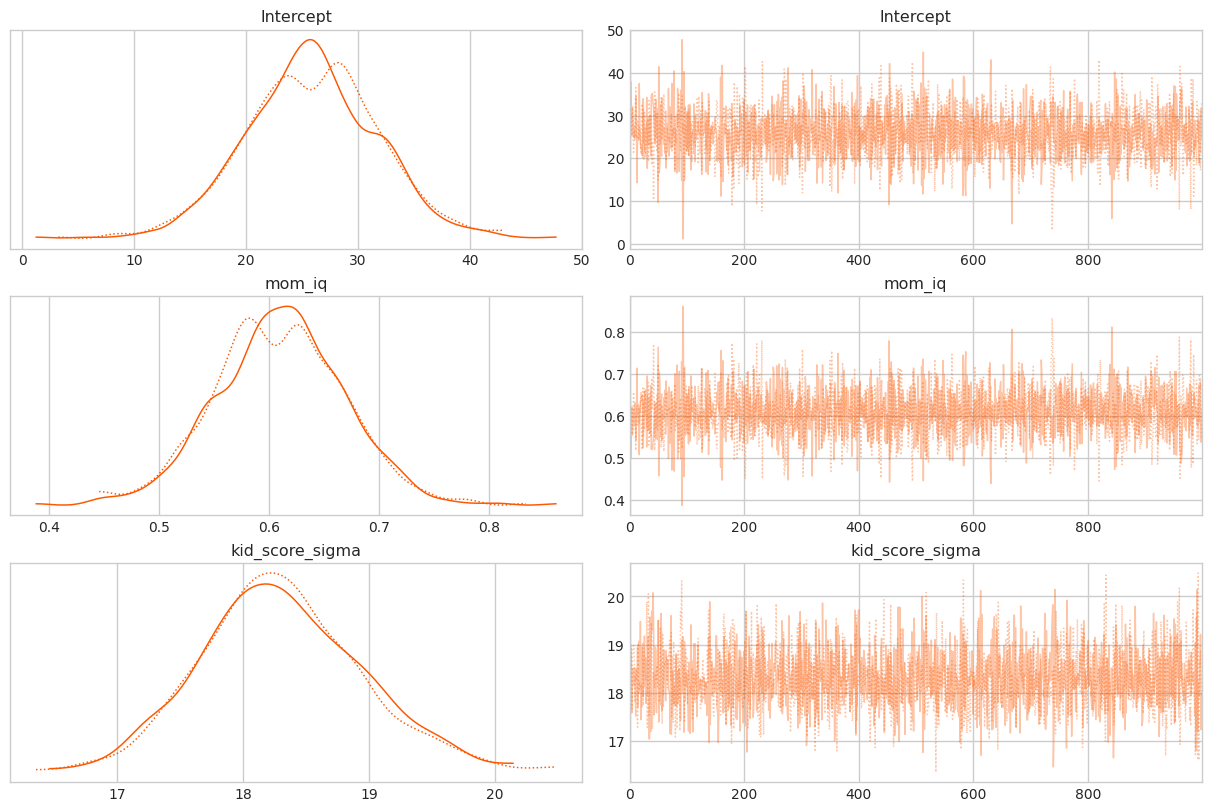

In [ ]:
az.plot_trace(m3_fit, figsize=(12,8));

## Plot posterior distributions

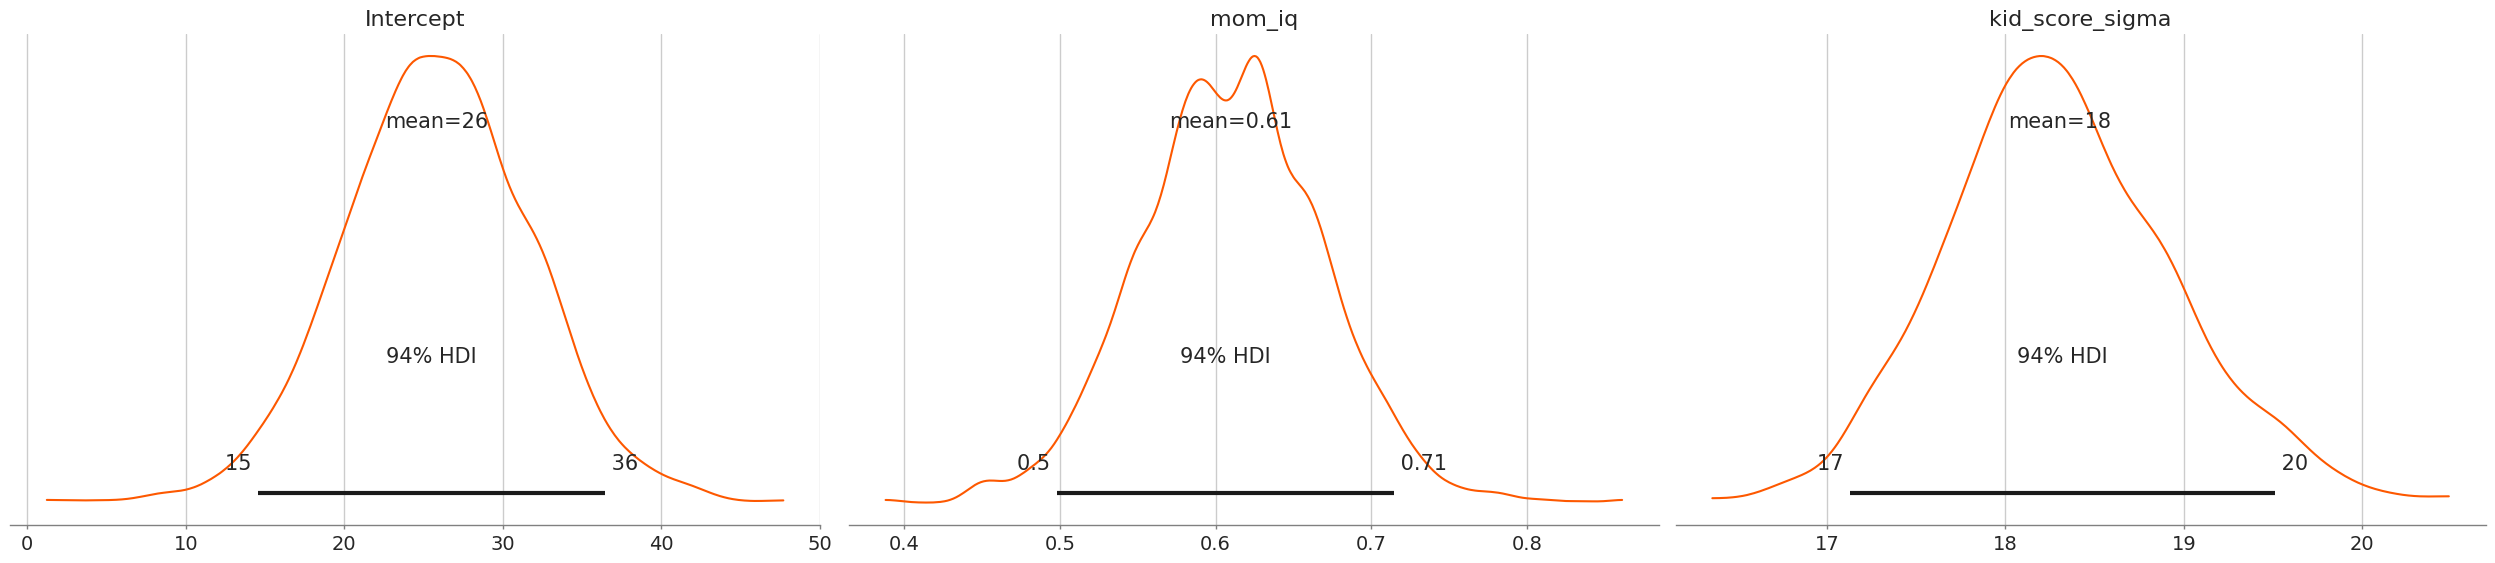

In [ ]:
az.plot_posterior(m3_fit);

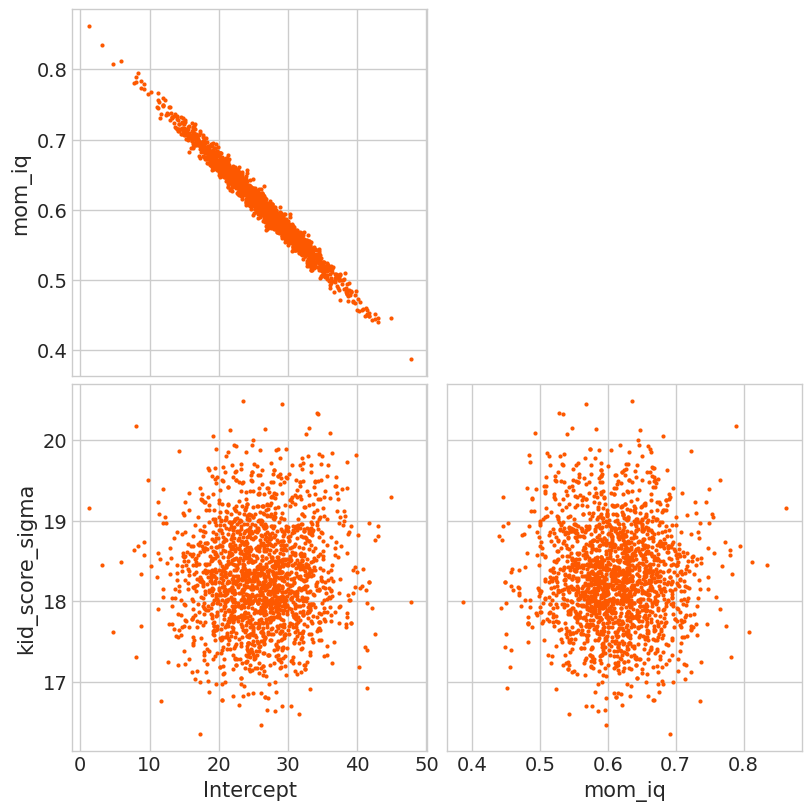

In [ ]:
az.plot_pair(m3_fit, figsize=(8,8));

In [ ]:
m3_df = az.extract_dataset(m3_fit).to_dataframe()[['Intercept', 'mom_iq', 'kid_score_sigma']]
m3_df

Intercept    mom_iq  kid_score_sigma
chain draw                                      
0     0     36.658970  0.483414        17.493409
      1     12.009516  0.748791        18.973257
      2     37.960137  0.500685        18.941705
      3     29.471931  0.575500        18.830302
      4     25.221287  0.621776        17.583281
...               ...       ...              ...
1     995   18.257933  0.697086        18.652771
      996   19.799033  0.665003        18.557514
      997   17.218996  0.690180        18.887258
      998   29.476039  0.582199        18.249455
      999   33.194386  0.549062        17.914248

[2000 rows x 3 columns]

In [ ]:
m3_df.describe().T.round(2)

count   mean   std    min    25%    50%    75%    max
Intercept        2000.0  25.85  5.92   1.18  21.97  25.87  29.60  47.74
mom_iq           2000.0   0.61  0.06   0.39   0.57   0.61   0.65   0.86
kid_score_sigma  2000.0  18.30  0.63  16.35  17.88  18.27  18.71  20.49

## Interpret results

In [ ]:
az.summary(m3_fit).round(1)

mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept        25.8  5.9    14.6     36.4        0.1      0.1    3515.0   
mom_iq            0.6  0.1     0.5      0.7        0.0      0.0    3496.0   
kid_score_sigma  18.3  0.6    17.1     19.5        0.0      0.0    3521.0   

                 ess_tail  r_hat  
Intercept          1323.0    1.0  
mom_iq             1369.0    1.0  
kid_score_sigma    1400.0    1.0

In [ ]:
posterior_predictive = m3.predict(m3_fit, kind="pps")
m3_fit

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

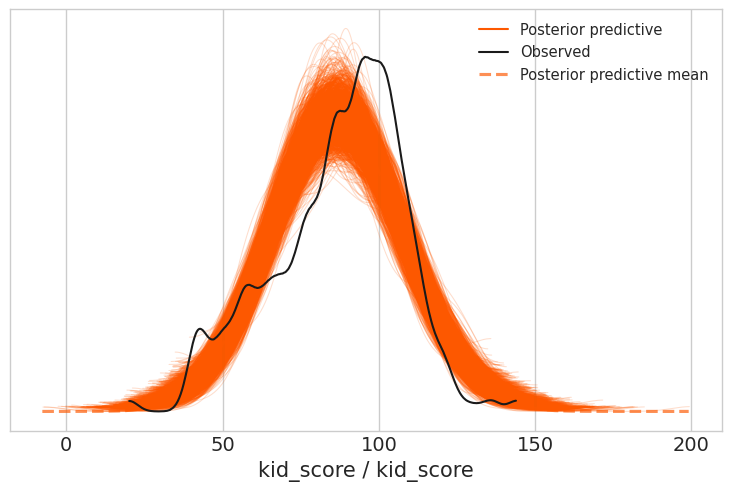

In [ ]:
az.plot_ppc(m3_fit);

In [ ]:
loo3 = az.loo(m3_fit)
loo3

Computed from 2000 posterior samples and 434 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1878.62    14.48
p_loo        2.94        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      434  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [ ]:
y_true = kidiq.kid_score.values
y_pred = m3_fit.posterior_predictive.mean(dim=("chain", "draw"))["kid_score"].values.T

m3_fit_r2_score = az.r2_score(y_true, y_pred)
m3_fit_r2_score

r2        0.200658
r2_std    0.000000
dtype: float64

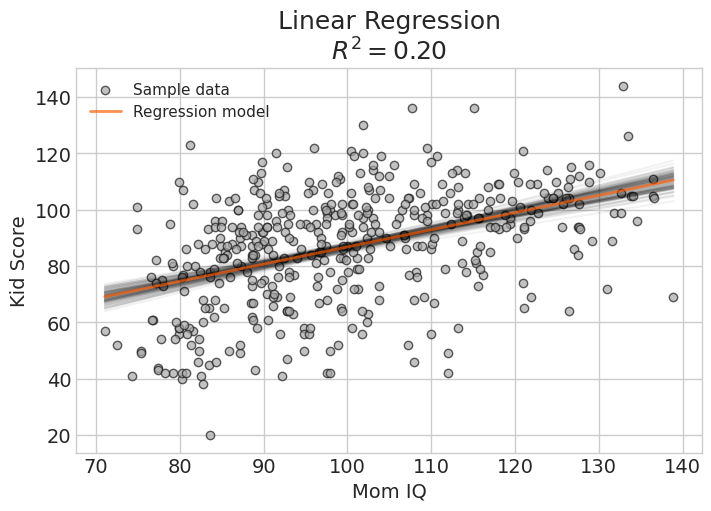

In [ ]:
# SOURCE: https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM.html

# Initialize random number generator
RANDOM_SEED = 8927
rng = default_rng(RANDOM_SEED)

fig, ax = plt.subplots(figsize=(7, 5))

x_axis = xr.DataArray(np.linspace(min(kidiq.mom_iq), max(kidiq.mom_iq), 2000), dims=["x_plot"])
mu_pred = m3_fit.posterior["Intercept"] + m3_fit.posterior["mom_iq"] * x_axis
mu_mean = mu_pred.mean(dim=("chain", "draw"))
mu_plot = mu_pred.stack(sample=("chain", "draw"))
random_subset = rng.permutation(np.arange(len(mu_plot.sample)))[:100]

plt.scatter(kidiq.mom_iq, kidiq.kid_score, edgecolor='k', facecolor='darkgray', alpha=0.7, label='Sample data')
plt.plot(x_axis, mu_plot.isel(sample=random_subset), color="black", alpha=0.05)
plt.plot(x_axis, mu_mean, color="C1", lw=2.0, label='Regression model')

ax.set_ylabel('Kid Score', fontsize=14)
ax.set_xlabel('Mom IQ', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Linear Regression\n$R^2= %.2f$' % m3_fit_r2_score[0], fontsize=18)

fig.tight_layout();

---

## Two predictors: one binary and one continuous (no interaction)

In [ ]:
sns.set_theme()

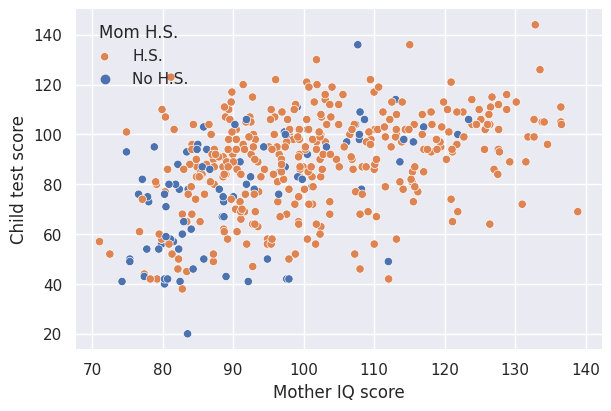

In [ ]:
f, ax = plt.subplots(figsize=(6, 4))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(data=kidiq, x="mom_iq", y="kid_score", hue="mom_hs", ax=ax)
plt.legend(title='Mom H.S.', loc='upper left', labels=['H.S.', 'No H.S.'])
plt.xlabel('Mother IQ score')
plt.ylabel('Child test score');

## Plot model

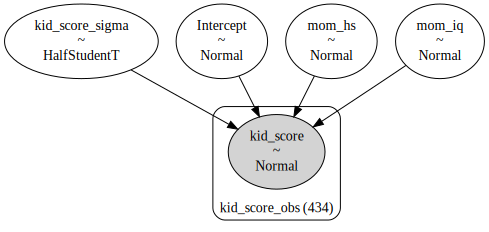

In [ ]:
m4 = bmb.Model('kid_score ~ 1 + mom_hs + mom_iq', data=kidiq)

m4.build()

m4.graph()

In [ ]:
m4

       Formula: kid_score ~ 1 + mom_hs + mom_iq
        Family: gaussian
          Link: mu = identity
  Observations: 434
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 86.7972, sigma: 357.5526)
            mom_hs ~ Normal(mu: 0.0, sigma: 124.2132)
            mom_iq ~ Normal(mu: 0.0, sigma: 3.4018)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 20.3872)

## Plot prior parameter distributions

In [ ]:
az.style.use(['arviz-white', 'arviz-purplish'])

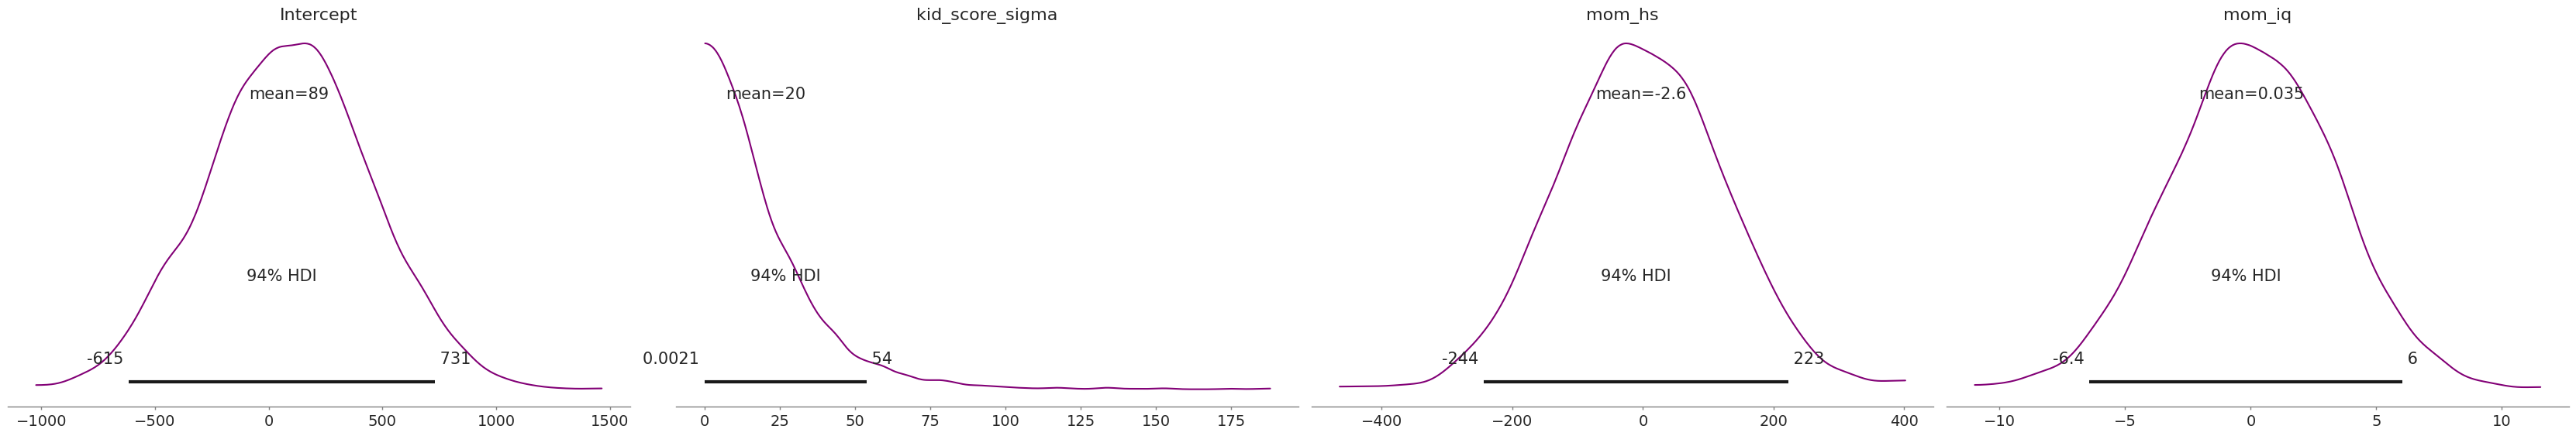

In [ ]:
m4.plot_priors();

## Fit model

In [ ]:
# https://discourse.pymc.io/t/using-az-compare-with-bambi-models/12301/3
# idata = pm.compute_log_likelihood(idata)

m4_fit = m4.fit(idata_kwargs=dict(log_likelihood=True))

m4_fit

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

## Plot MCMC diagnostics

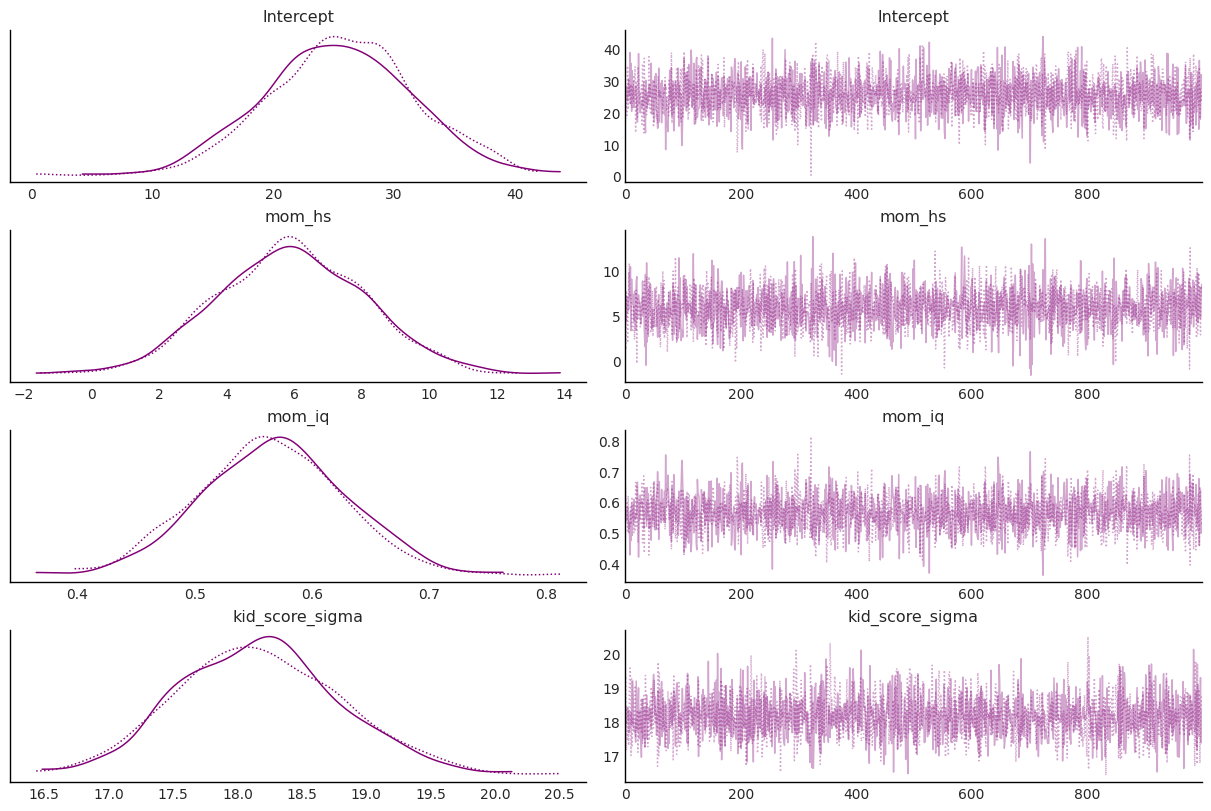

In [ ]:
az.plot_trace(m4_fit, figsize=(12,8));

## Plot posterior distributions

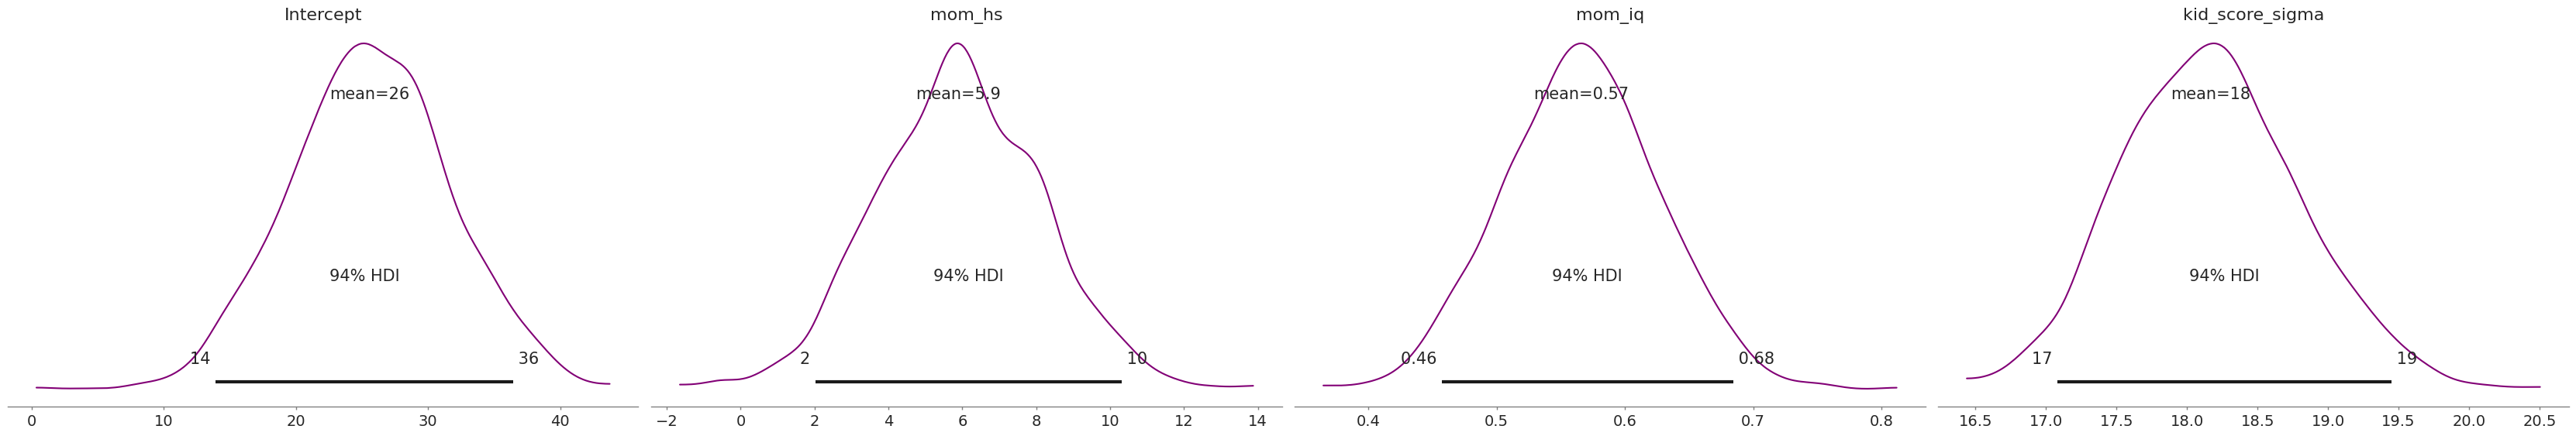

In [ ]:
az.plot_posterior(m4_fit);

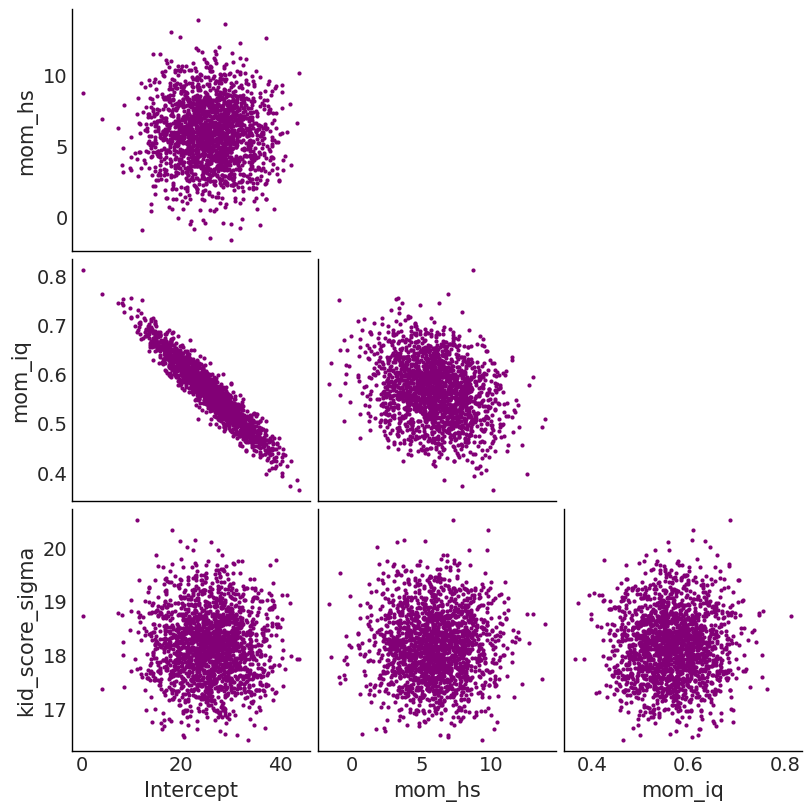

In [ ]:
az.plot_pair(m4_fit, figsize=(8,8));

In [ ]:
m4_df = az.extract_dataset(m4_fit).to_dataframe()[['Intercept', 'mom_hs', 'mom_iq', 'kid_score_sigma']]
m4_df

Intercept    mom_hs    mom_iq  kid_score_sigma
chain draw                                                
0     0     15.707835  4.456020  0.657311        18.450386
      1     28.220229  6.487266  0.556731        18.338128
      2     28.156260  4.348470  0.539557        17.956958
      3     25.338185  7.180509  0.554563        18.440050
      4     23.638521  5.437366  0.585327        18.065891
...               ...       ...       ...              ...
1     995   34.197228  7.045344  0.461557        18.581663
      996   18.033728  5.206561  0.650490        16.787227
      997   27.332676  2.867086  0.576645        18.274420
      998   23.262535  8.323446  0.572314        18.457355
      999   27.167725  7.804236  0.530160        18.816632

[2000 rows x 4 columns]

In [ ]:
m4_df.describe().T.round(2)

count   mean   std    min    25%    50%    75%    max
Intercept        2000.0  25.57  6.02   0.33  21.54  25.57  29.58  43.78
mom_hs           2000.0   5.90  2.24  -1.66   4.37   5.90   7.45  13.89
mom_iq           2000.0   0.57  0.06   0.36   0.53   0.57   0.61   0.81
kid_score_sigma  2000.0  18.17  0.63  16.43  17.72  18.15  18.59  20.51

## Interpret results

In [ ]:
az.summary(m4_fit).round(1)

mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept        25.6  6.0    13.9     36.5        0.1      0.1    2565.0   
mom_hs            5.9  2.2     2.0     10.3        0.0      0.0    2938.0   
mom_iq            0.6  0.1     0.5      0.7        0.0      0.0    2347.0   
kid_score_sigma  18.2  0.6    17.1     19.5        0.0      0.0    2812.0   

                 ess_tail  r_hat  
Intercept          1633.0    1.0  
mom_hs             1678.0    1.0  
mom_iq             1662.0    1.0  
kid_score_sigma    1600.0    1.0

In [ ]:
posterior_predictive = m4.predict(m4_fit, kind="pps")
m4_fit

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

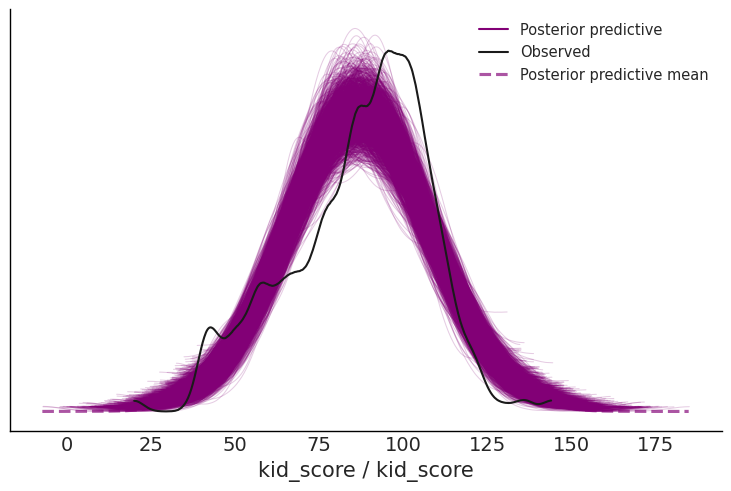

In [ ]:
az.plot_ppc(m4_fit);

In [ ]:
loo4 = az.loo(m4_fit)
loo4

Computed from 2000 posterior samples and 434 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1876.15    14.22
p_loo        4.13        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      434  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

In [ ]:
y_true = kidiq.kid_score.values
y_pred = m4_fit.posterior_predictive.mean(dim=("chain", "draw"))["kid_score"].values.T

m4_fit_r2_score = az.r2_score(y_true, y_pred)
m4_fit_r2_score

r2        0.215978
r2_std    0.000000
dtype: float64

### Version 1

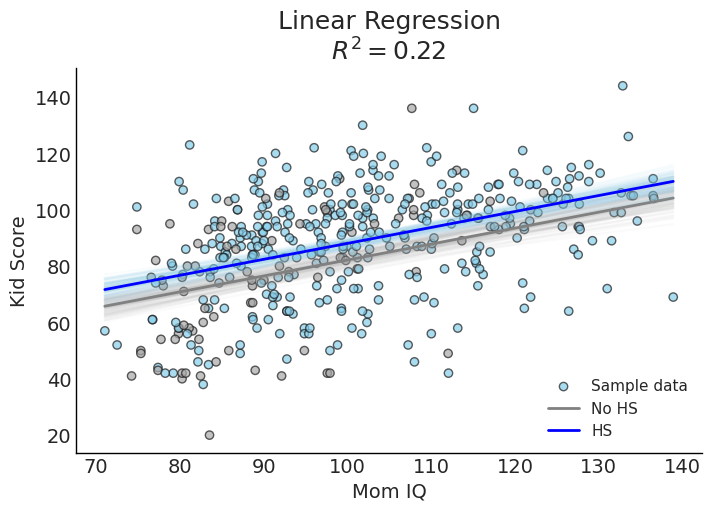

In [ ]:
# SOURCE: https://docs.pymc.io/en/v3/pymc-examples/examples/generalized_linear_models/GLM.html

# Initialize random number generator
RANDOM_SEED = 8927
rng = default_rng(RANDOM_SEED)


fig, ax = plt.subplots(figsize=(7, 5))

colors = {1:'skyblue', 0:'darkgray'}

# Scatter plot of data points (color by value of mom_hs)
x_axis = xr.DataArray(np.linspace(min(kidiq.mom_iq), max(kidiq.mom_iq), 2000), dims=["x_plot"])
ax.scatter(kidiq.mom_iq, kidiq.kid_score, edgecolor='k', facecolor=kidiq.mom_hs.map(colors), alpha=0.7, label='Sample data')

# No HS: Posterior regression lines
mu_pred_no_hs = m4_fit.posterior["Intercept"] + m4_fit.posterior["mom_iq"] * x_axis
mu_mean_no_hs = mu_pred_no_hs.mean(dim=("chain", "draw"))
mu_plot_no_hs = mu_pred_no_hs.stack(sample=("chain", "draw"))
random_subset = rng.permutation(np.arange(len(mu_plot_no_hs.sample)))[:100]

plt.plot(x_axis, mu_plot_no_hs.isel(sample=random_subset), color="darkgray", alpha=0.05)
plt.plot(x_axis, mu_mean_no_hs, color="gray", lw=2.0, label='No HS')

# HS: Posterior regression lines
mu_pred_hs = (m4_fit.posterior["Intercept"]+m4_fit.posterior["mom_hs"]) + m4_fit.posterior["mom_iq"] * x_axis
mu_mean_hs = mu_pred_hs.mean(dim=("chain", "draw"))
mu_plot_hs = mu_pred_hs.stack(sample=("chain", "draw"))
random_subset = rng.permutation(np.arange(len(mu_plot_hs.sample)))[:100]

plt.plot(x_axis, mu_plot_hs.isel(sample=random_subset), color="skyblue", alpha=0.05)
plt.plot(x_axis, mu_mean_hs, color="blue", lw=2.0, label='HS')

# Plot title and axis labels
ax.set_ylabel('Kid Score', fontsize=14)
ax.set_xlabel('Mom IQ', fontsize=14)
ax.legend(fontsize=11)
ax.set_title('Linear Regression\n$R^2= %.2f$' % m4_fit_r2_score[0], fontsize=18)

fig.tight_layout();

### Version 2

In [ ]:
# SOURCES:
# https://python.arviz.org/en/stable/api/generated/arviz.plot_lm.html
# https://utkarsh-maheshwari.medium.com/how-to-use-plot-lm-part-i-1f1cb099503e

x_axis = xr.DataArray(np.linspace(min(kidiq.mom_iq), max(kidiq.mom_iq), len(kidiq)), dims=["x_axis"])

m4_fit.posterior["y_no_hs"] = m4_fit.posterior["Intercept"] + m4_fit.posterior["mom_iq"] * x_axis

m4_fit.posterior["y_hs"] = (m4_fit.posterior["Intercept"]+m4_fit.posterior["mom_hs"]) + m4_fit.posterior["mom_iq"] * x_axis

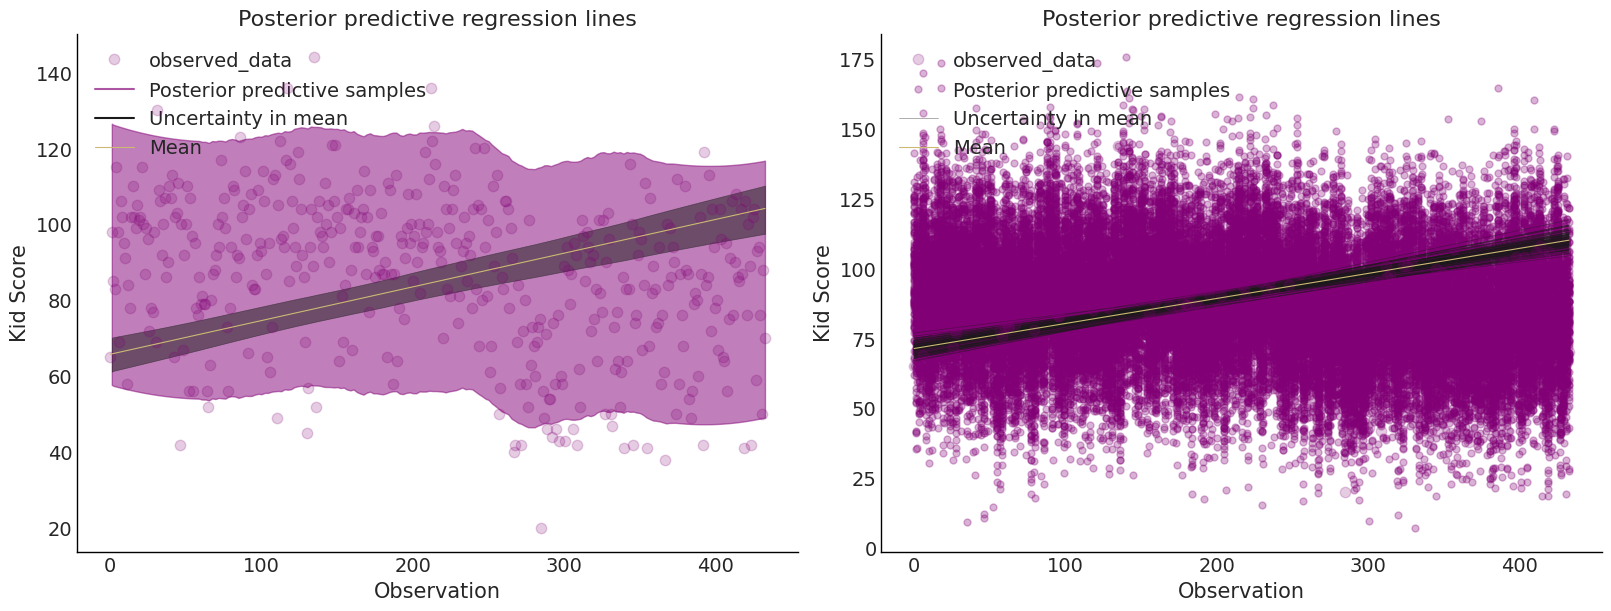

In [ ]:
_, axs = plt.subplots(1, 2, figsize=(16, 6))
az.plot_lm(idata=m4_fit, y="kid_score", num_samples=100, axes=axs[0], y_model="y_no_hs", kind_pp="hdi", kind_model="hdi")
az.plot_lm(idata=m4_fit, y="kid_score", num_samples=100, axes=axs[1], y_model="y_hs")
for ax in axs.flat:
    ax.set_title("Posterior predictive regression lines")
    ax.set_ylabel("Kid Score")
    ax.set_xlabel("Observation");

---

# Compare models

In [ ]:
compare_dict = {"Model 1": loo1,
                "Model 2": loo2,
                "Model 3": loo3,
                "Model 4": loo4}

az.compare(compare_dict).round(2)

rank  elpd_loo  p_loo  elpd_diff  weight     se   dse  warning scale
Model 4     0  -1876.15   4.13       0.00    0.78  14.22  0.00    False   log
Model 3     1  -1878.62   2.94       2.47    0.19  14.48  2.77    False   log
Model 2     2  -1914.84   3.11      38.68    0.02  13.82  8.38    False   log
Model 1     3  -1926.22   1.86      50.07    0.00  14.10  9.40    False   log

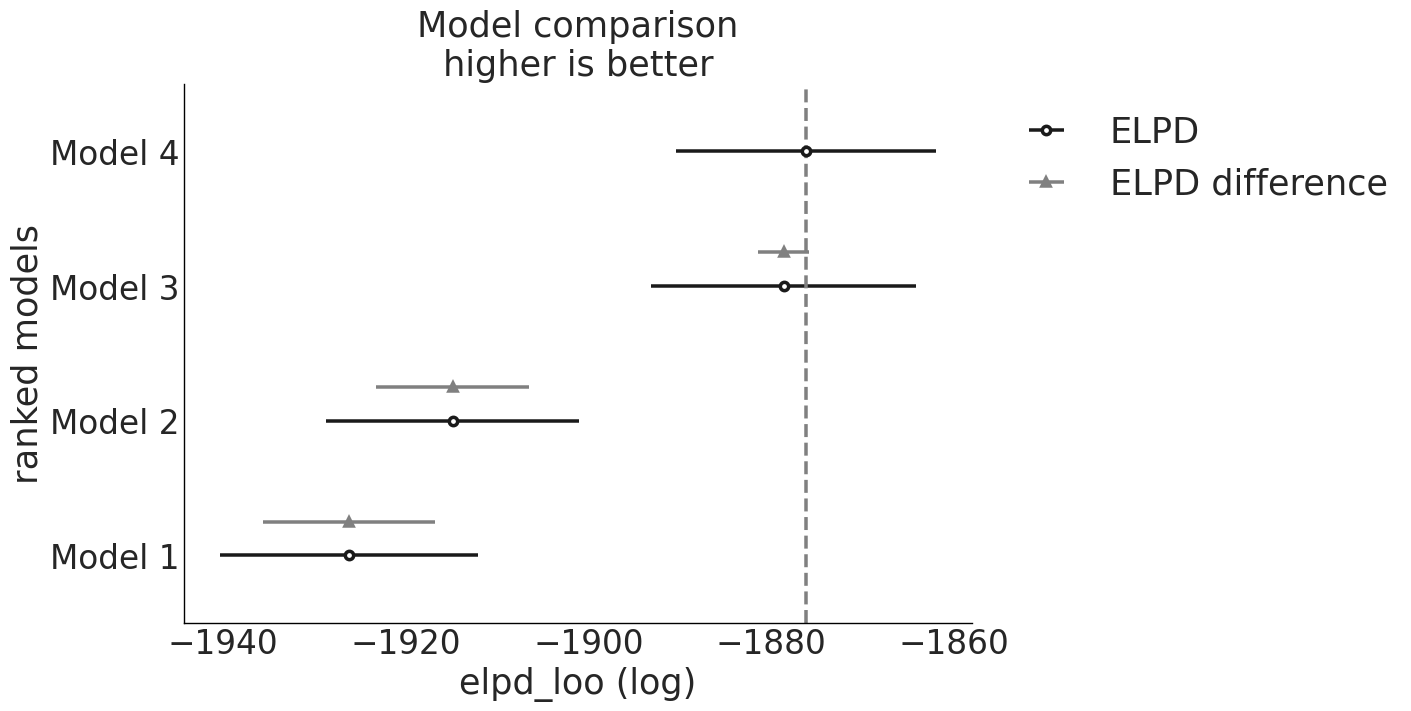

In [ ]:
az.plot_compare(az.compare(compare_dict), figsize=(14, 7));

---

# Exercise:

### Estimate the relationship between `weight` and `height` in a sample of adults [[Source]](https://bookdown.org/content/4857/geocentric-models.html#linear-prediction)

### Read dataset into DataFrame

In [ ]:
d = pd.read_csv('https://raw.githubusercontent.com/cbrownley/2023ODSCWest/main/data/Howell1.csv', sep=';')

### Filter for adults

In [ ]:
d2 = d[d.age >= 18]
d2

height     weight   age  male
0    151.765  47.825606  63.0     1
1    139.700  36.485807  63.0     0
2    136.525  31.864838  65.0     0
3    156.845  53.041914  41.0     1
4    145.415  41.276872  51.0     0
..       ...        ...   ...   ...
534  162.560  47.031821  27.0     0
537  142.875  34.246196  31.0     0
540  162.560  52.163080  31.0     1
541  156.210  54.062497  21.0     0
543  158.750  52.531624  68.0     1

[352 rows x 4 columns]

### Plot data

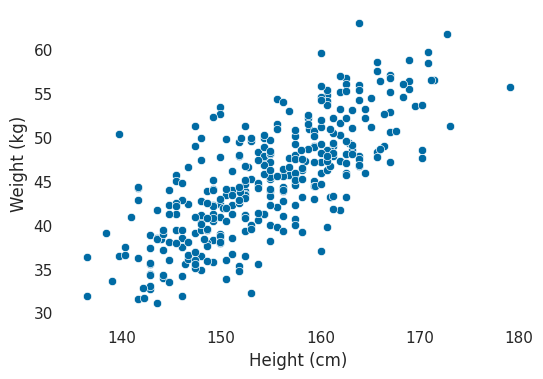

In [ ]:
f, ax = plt.subplots(figsize=(6, 4))
sns.despine(f, left=True, bottom=True)
sns.scatterplot(x="height", y="weight", data=d2, ax=ax)
plt.xlabel('Height (cm)')
plt.ylabel('Weight (kg)');

### Plot model

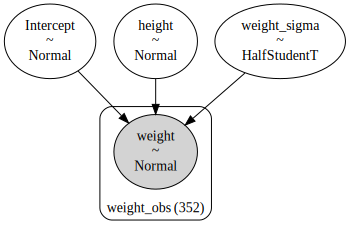

       Formula: weight ~ 1 + height
        Family: gaussian
          Link: mu = identity
  Observations: 352
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 44.9905, sigma: 322.7179)
            height ~ Normal(mu: 0.0, sigma: 2.0849)
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 6.4475)

### Plot prior parameter distributions

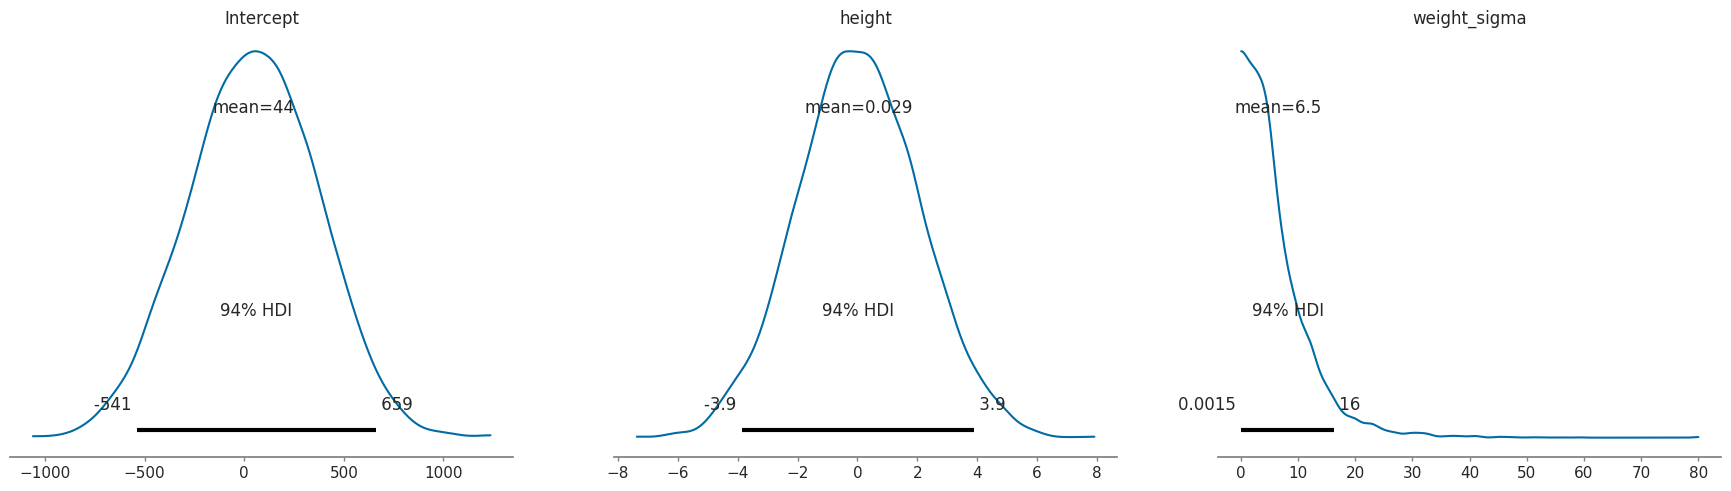

### Fit model

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

### Plot MCMC diagnostics

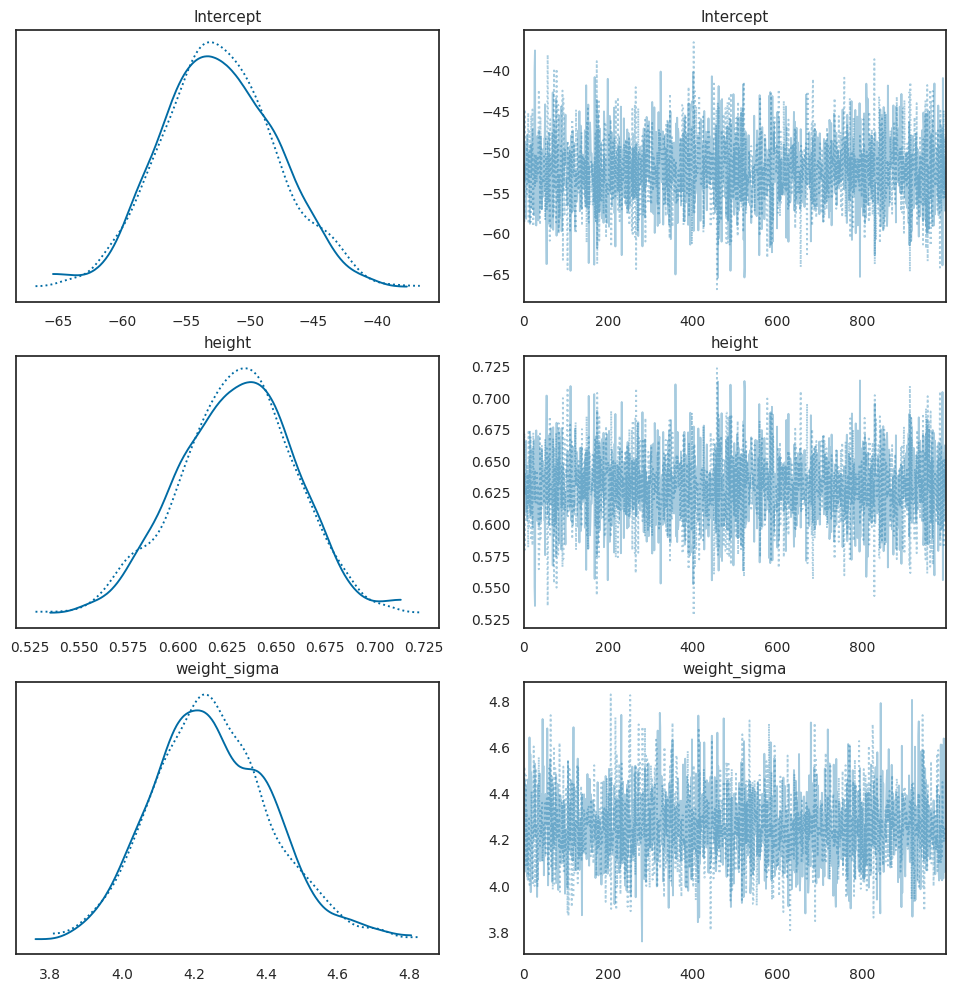

### Plot posterior distributions

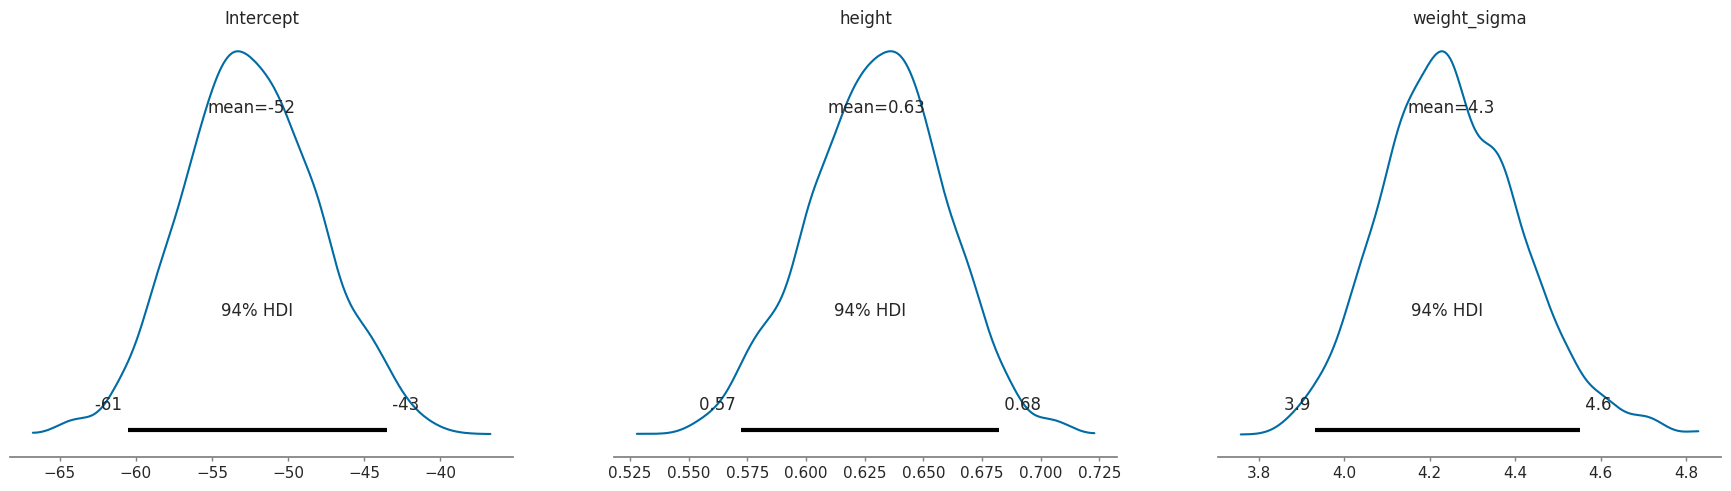

### Interpret results

mean   sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
Intercept    -52.4  4.6   -60.5    -43.5        0.1      0.1    3046.0   
height         0.6  0.0     0.6      0.7        0.0      0.0    3073.0   
weight_sigma   4.3  0.2     3.9      4.6        0.0      0.0    2924.0   

              ess_tail  r_hat  
Intercept       1274.0    1.0  
height          1331.0    1.0  
weight_sigma    1664.0    1.0

### Plot posterior predictive distribution

Inference data with groups:
	> posterior
	> posterior_predictive
	> log_likelihood
	> sample_stats
	> observed_data

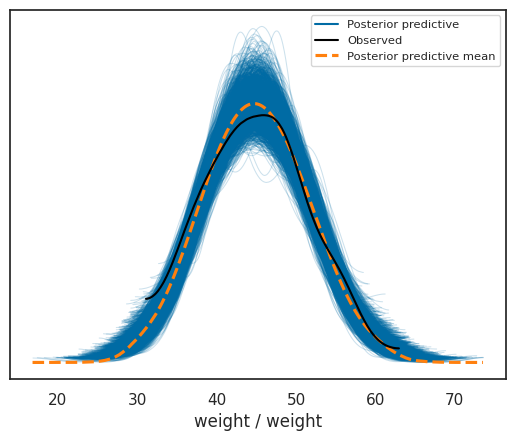

### Compute loo

Computed from 2000 posterior samples and 352 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -1010.18    13.99
p_loo        3.12        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      352  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%